In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


### Reading Gene and Variation Data

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### Reading Text Data

In [3]:
data_text = pd.read_csv('training/training_text',sep='\|\|',engine='python',names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of text

In [4]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# loading words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ',total_text) # Special Char
        
        total_text = re.sub('\s+', ' ', total_text) # Multiple_spaces
    
        total_text = total_text.lower() # Converting all the chars to lower case
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
                
            data_text[column][index] = string

In [165]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 11998.744431699975 seconds


In [9]:
# Merging both gene_variations and text data based on ID

result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' '+result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [13]:
# Test, Train and Cross Validation Split

#Splitting data into train, test and cross validation(64:20:16)

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true,test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


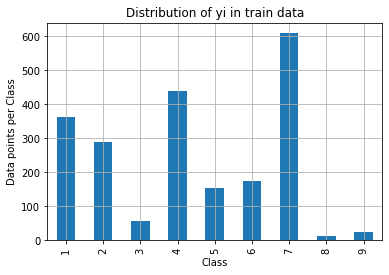

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


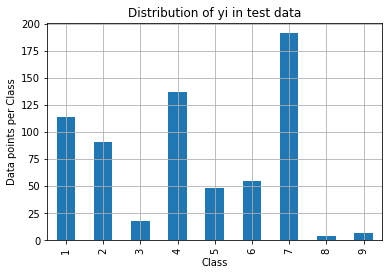

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


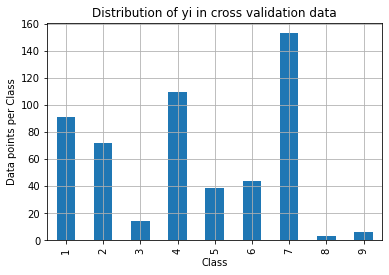

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [15]:
# it returns a dict, keys as class labels and values as the number of data points in that class

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(',np.round((train_class_distribution.values[i]/train_df.shape[0]*100),3),'%)')
   
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(',np.round((test_class_distribution.values[i]/test_df.shape[0]*100),3),'%)')


print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(',np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100),3),'%)')


In [105]:
# Prediction using a 'Random' Mdoel

def plot_confusion_matrix(test_y, predict_y): # this function plots the confusion matrices given y_i, y_i_hat.
    C = confusion_matrix(test_y, predict_y)     # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    
    A = ((C.T)/(C.sum(axis=1)).T)#divide each element of the confusion matrix with the sum of elements in that column
   # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B = (C/C.sum(axis=0))#divide each element of the confusion matrix with the sum of elements in that row
     # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    
    labels = [1,2,3,4,5,6,7,8,9]
      # representing A in heatmap format
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot= True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Column Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4642396290278756
Log loss on Test Data using Random Model 2.4630668011393886
-------------------- Confusion matrix --------------------


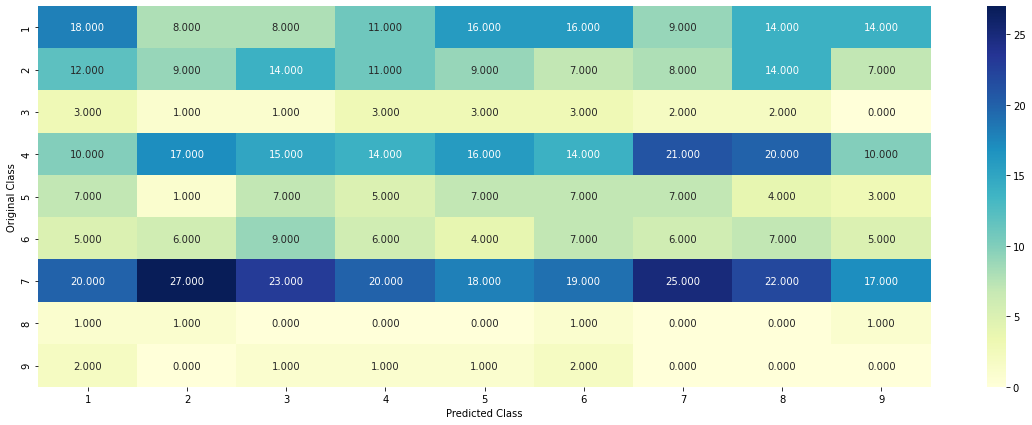

-------------------- Precision matrix (Column Sum=1) --------------------


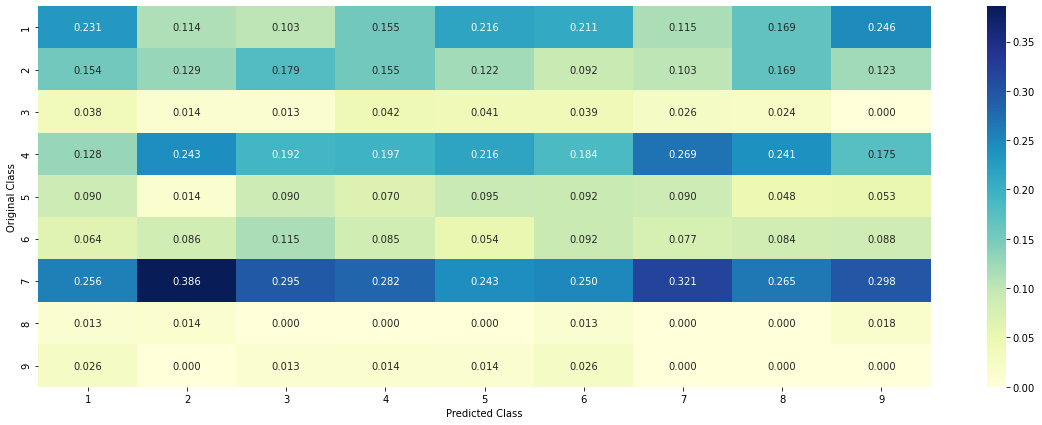

-------------------- Recall matrix (Row sum=1) --------------------


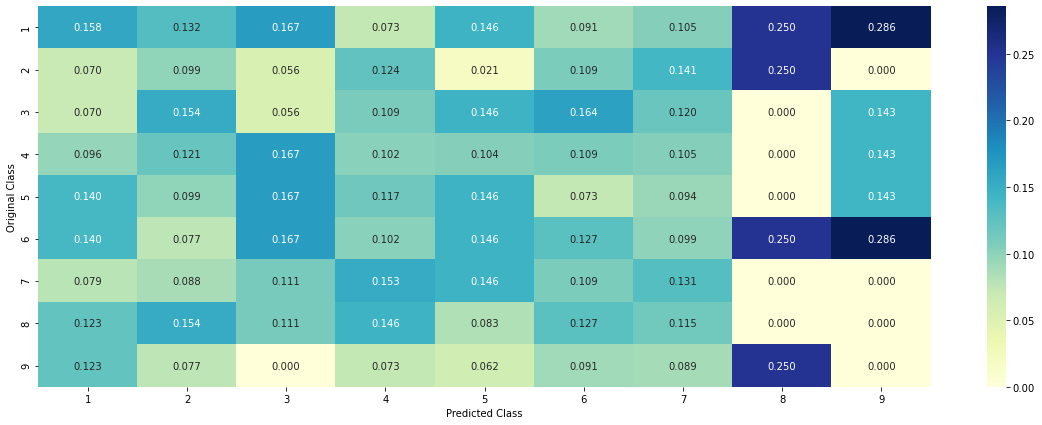

In [108]:
# we need to generate 9 numbers and the sum of numbers should be 1


test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [109]:
# UniVariate Analysis

def get_gv_fea_dict(alpha, feature, df):
    
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
            
        gv_dict[i] = vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea=[]
    
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
            
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [110]:
#2. How many categories are there and how they are distributed?

unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes: ', unique_genes.shape[0])

print(unique_genes.head(10))

Number of Unique Genes:  236
BRCA1     175
TP53      106
EGFR       88
PTEN       82
BRCA2      76
KIT        61
BRAF       59
PDGFRA     43
ALK        42
ERBB2      41
Name: Gene, dtype: int64


In [22]:
print("Ans: There are", unique_genes.shape[0], "different categories of genes in the train data, and they are distribued as follows",)

Ans: There are 236 different categories of genes in the train data, and they are distribued as follows


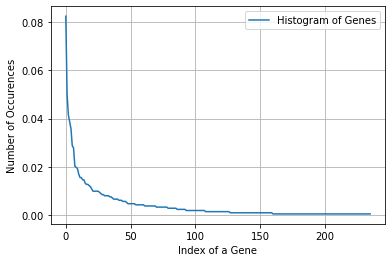

In [23]:
s = sum(unique_genes.values)
h = unique_genes.values/s;
plt.plot(h, label="Histogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

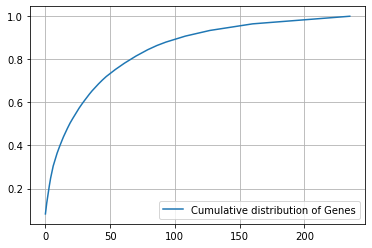

In [24]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [25]:
# Feature the Gene feature

#1. response coding

alpha = 1

train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [34]:
print("train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature: (2124, 9)


In [26]:
# One-hot encoding feature

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df["Gene"])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [27]:
train_df['Gene'].head()

721      ERBB2
910     PDGFRA
395       TP53
2471     BRCA1
271       EGFR
Name: Gene, dtype: object

In [28]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 

In [29]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene features:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene features: (2124, 235)


For values of alpha =  1e-05 The log loss is: 1.1681983098206083
For values of alpha =  0.0001 The log loss is: 1.1493716830309755
For values of alpha =  0.001 The log loss is: 1.20283012715097
For values of alpha =  0.01 The log loss is: 1.327963596166117
For values of alpha =  0.1 The log loss is: 1.443342367844334
For values of alpha =  1 The log loss is: 1.4956072108653158


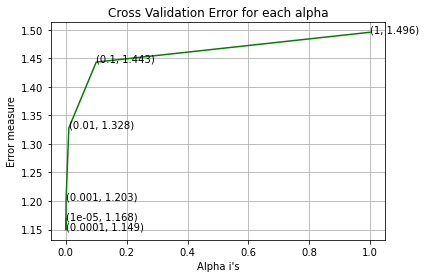

For values of best alpha = 0.0001 The train log loss is: 0.9847612946618894
For values of best alpha = 0.0001 The Cross Validation log loss is: 1.1493716830309755
For values of best alpha = 0.0001 The test log loss is: 1.2065621116630851


In [111]:
# How good is this gene feature in predicting y_i?

alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array=[]
for i in alpha:
    clf =SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)

    clf.fit(train_gene_feature_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_,eps=1e-15))
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c= 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss ='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha =' , alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The Cross Validation log loss is:", log_loss(y_cv,predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))


In [31]:
# Gene Stable feature stable or not

print("How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], "genes in train dataset?")

test_coverage=test_df[test_df["Gene"].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('\n1. In test data', test_coverage, 'out of', test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In Cross Validation data', cv_coverage,'out of', cv_df.shape[0], ":",(cv_coverage/cv_df.shape[0])*100)

How many data points in Test and CV datasets are covered by the  236 genes in train dataset?

1. In test data 646 out of 665 : 97.14285714285714
2. In Cross Validation data 517 out of 532 : 97.18045112781954


In [32]:
# Variation Feature

unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
#top ten variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1931
Truncating_Mutations    60
Amplification           49
Deletion                41
Fusions                 22
Overexpression           4
Q61H                     3
Q61L                     3
G12V                     3
T58I                     3
G35R                     2
Name: Variation, dtype: int64


In [33]:
print("Ans: There are", unique_variations.shape[0], "different categories of variations in the train data, and they are distributed as follows, ")

Ans: There are 1931 different categories of variations in the train data, and they are distributed as follows, 


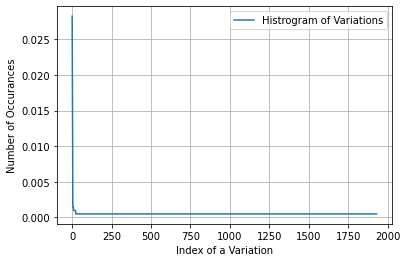

In [34]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02824859 0.05131827 0.07062147 ... 0.99905838 0.99952919 1.        ]


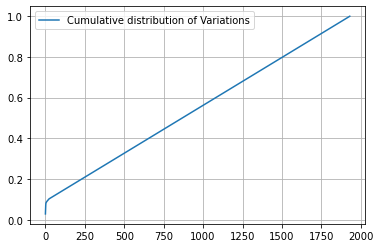

In [35]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [112]:
# Featurizing the variation features

# Alpha is used for laplace smoothing
alpha = 1

#train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
#test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
#cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [68]:
# Always use response coding in train data

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: ", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:  (2124, 9)


In [113]:
# One-hot encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [114]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape) 

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1959)


For values of alpha =  1e-05 The log loss is:  1.6941702227248356
For values of alpha =  0.0001 The log loss is:  1.690043142659349
For values of alpha =  0.001 The log loss is:  1.6996653863819384
For values of alpha =  0.01 The log loss is:  1.7050053868468802
For values of alpha =  0.1 The log loss is:  1.7096067253328597
For values of alpha =  1 The log loss is:  1.7134355403139667


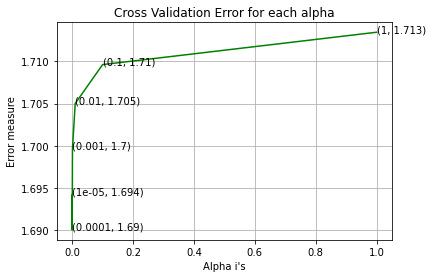

For values of best alpha = 0.0001 The train log loss is:  0.6983045893945337
For values of best alpha = 0.0001 The cross validation log loss is:  1.690043142659349
For values of best alpha = 0.0001 The test log loss is:  1.7249122087581432


In [115]:
# Building a model

alpha = [10 ** x for x in range(-5,1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss ='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels= clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is: ", log_loss(y_cv, predict_y, labels=clf.classes_, eps = 1e-15))
          
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is: ", log_loss(y_train,predict_y, labels=clf.classes_, eps =1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is: ", log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is: ", log_loss(y_test, predict_y,labels=clf.classes_,eps=1e-15))

In [40]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1931  genes in test and cross validation data sets?
Ans
1. In test data 65 out of 665 : 9.774436090225564
2. In cross validation data 59 out of  532 : 11.090225563909774


In [116]:
#Text Feature
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [117]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob +=math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i]= math.exp(sum_prob/len(row['TEXT'].split()))
            row_index +=1
        return text_feature_responseCoding

In [43]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
train_text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54518


In [118]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [119]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [120]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [121]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


In [122]:
# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

In [123]:
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


In [124]:

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

In [125]:
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [128]:
print(Counter(sorted_text_occur))

NameError: name 'sorted_text_occur' is not defined

In [130]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

For values of alpha =  1e-05 The log loss is: 1.2447733353134784
For values of alpha =  0.0001 The log loss is: 1.1023040940919904
For values of alpha =  0.001 The log loss is: 1.1227871721515195
For values of alpha =  0.01 The log loss is: 1.2575617539924184
For values of alpha =  0.1 The log loss is: 1.4897850838373758
For values of alpha =  1 The log loss is: 1.6776973893235145


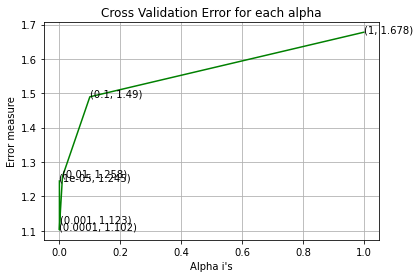

For values of best alpha =  0.0001 The train log loss is: 0.6402417176179547
For values of best alpha =  0.0001 The cross validation log loss is: 1.1023040940919904
For values of best alpha =  0.0001 The test log loss is: 1.2596988304779777


In [129]:

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [131]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [132]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.385 % of word of test data appeared in train data
98.259 % of word of Cross Validation appeared in train data


## Machine Learning Models

In [133]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [134]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [135]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [136]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [137]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56712)
(number of data points * number of features) in test data =  (665, 56712)
(number of data points * number of features) in cross validation data = (532, 56712)


In [64]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Hyper Parameter Tuning

for alpha = 1e-05
Log Loss : 1.1970723291895256
for alpha = 0.0001
Log Loss : 1.1839961156069334
for alpha = 0.001
Log Loss : 1.1809594030280564
for alpha = 0.1
Log Loss : 1.1615961272967101
for alpha = 1
Log Loss : 1.2192892430817384
for alpha = 10
Log Loss : 1.4265055213436122
for alpha = 100
Log Loss : 1.3617005268353097
for alpha = 1000
Log Loss : 1.3051311301726507


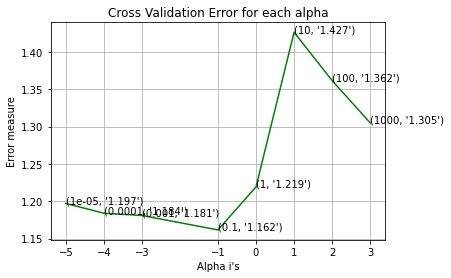

For values of best alpha =  0.1 The train log loss is: 0.8499565087037734
For values of best alpha =  0.1 The cross validation log loss is: 1.1615961272967101
For values of best alpha =  0.1 The test log loss is: 1.3223579335571187


In [138]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing the Model with best hyper parameters

Log Loss : 1.1615961272967101
Number of missclassified point : 0.34398496240601506
-------------------- Confusion matrix --------------------


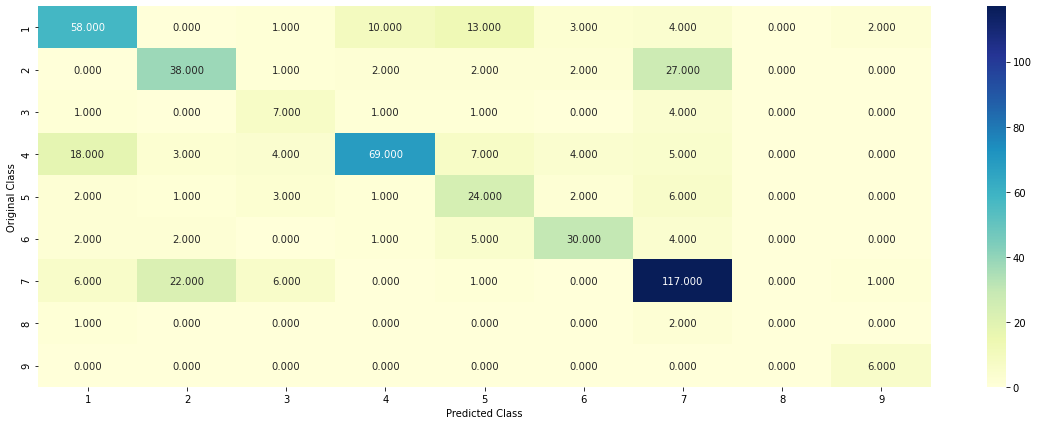

-------------------- Precision matrix (Column Sum=1) --------------------


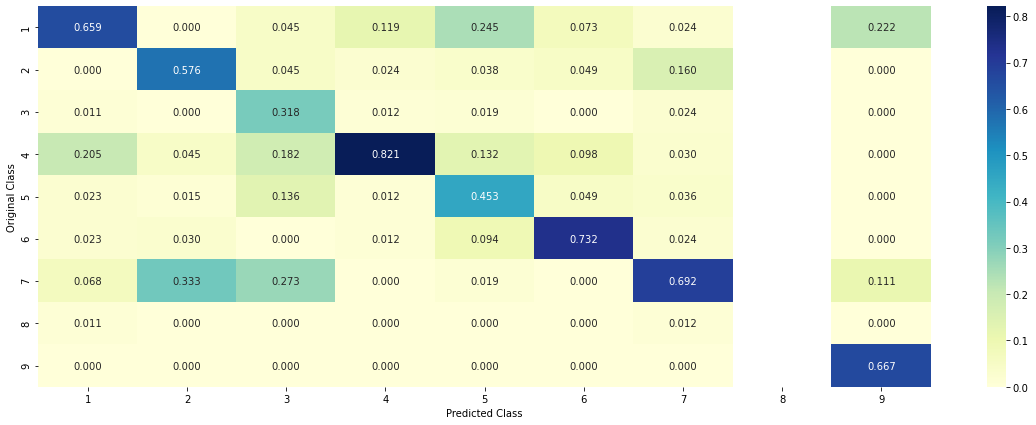

-------------------- Recall matrix (Row sum=1) --------------------


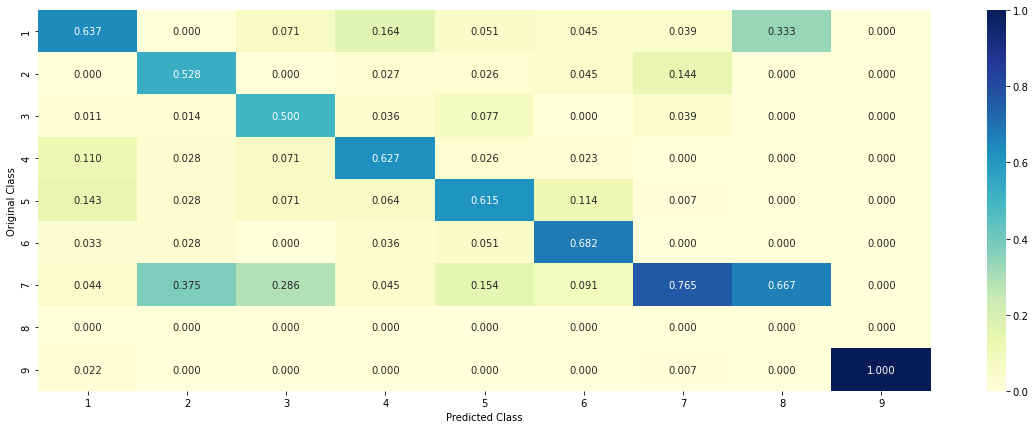

In [139]:

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Feature Importance, Correctly Classified Point

In [67]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0973 0.2481 0.0094 0.125  0.0409 0.037  0.4309 0.0066 0.0049]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [68]:
test_df['TEXT'].iloc[test_point_index]

'We sought to identify fibroblast growth factor receptor 2 (FGFR2) kinase domain mutations that confer resistance to the pan-FGFR inhibitor, dovitinib, and explore the mechanism of action of the drug-resistant mutations. We cultured BaF3 cells overexpressing FGFR2 in high concentrations of dovitinib and identified 14 dovitinib-resistant mutations, including the N550K mutation observed in 25% of FGFR2mutant endometrial cancers (ECs). Structural and biochemical in vitro kinase analyses, together with BaF3 proliferation assays, showed that the resistance mutations elevate the intrinsic kinase activity of FGFR2. BaF3 lines were used to assess the ability of each mutation to confer cross-resistance to PD173074 and ponatinib. Unlike PD173074, ponatinib effectively inhibited all the dovitinib-resistant FGFR2 mutants except the V565I gatekeeper mutation, suggesting ponatinib but not dovitinib targets the active conformation of FGFR2 kinase. EC cell lines expressing wild-type FGFR2 were relativ

In [69]:
no_feature

100

In [70]:
test_df['Gene'].iloc[test_point_index]

'FGFR2'

In [71]:
test_df['Variation'].iloc[test_point_index]

'V564I'

In [72]:
clf.coef_.shape

(9, 56712)

In [73]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

array([28355, 27745, 27740, 27739, 27737, 27729, 27723, 27721, 27715,
       27746, 27714, 27696, 27691, 27690, 27689, 27679, 27678, 27674,
       27672, 27701, 27747, 27748, 27750, 27846, 27845, 27840, 27835,
       27833, 27829, 27826, 27813, 27806, 27805, 27804, 27799, 27773,
       27762, 27760, 27757, 27755, 27753, 27752, 27670, 27669, 27668,
       27667, 27542, 27541, 27540, 27530, 27528, 27527, 27520, 27519,
       27501, 27497, 27491, 27490, 27472, 27469, 27467, 27466, 27463,
       27459, 27454, 27544, 27848, 27547, 27557, 27657, 27644, 27643,
       27637, 27626, 27609, 27608, 27607, 27601, 27599, 27597, 27590,
       27583, 27570, 27568, 27567, 27564, 27562, 27558, 27556, 27850,
       27851, 27853, 28069, 28068, 28067, 28066, 28065, 28063, 28062,
       28061], dtype=int64)

In [140]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [75]:
for i in range(10):
  test_point_index = i
  no_feature = 100
  predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
  print("Predicted Class :", predicted_cls[0])
  print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
  print("Actual Class :", test_y[test_point_index])
  indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:]
  print("-"*50)
  get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5667 0.0891 0.0097 0.1297 0.0423 0.0394 0.1114 0.0068 0.005 ]]
Actual Class : 5
--------------------------------------------------
14216 Text feature [reject] present in test data point [True]
18826 Text feature [admission] present in test data point [True]
22753 Text feature [1110] present in test data point [True]
22775 Text feature [1104] present in test data point [True]
22783 Text feature [1112] present in test data point [True]
22817 Text feature [1022] present in test data point [True]
22861 Text feature [1026] present in test data point [True]
24471 Text feature [met] present in test data point [True]
24944 Text feature [366] present in test data point [True]
25281 Text feature [usable] present in test data point [True]
25867 Text feature [entirety] present in test data point [True]
26304 Text feature [357] present in test data point [True]
26384 Text feature [1023] present in test data point [True]
26694 Text feature [1021

48400 Text feature [strategies] present in test data point [True]
48411 Text feature [promoted] present in test data point [True]
48484 Text feature [usual] present in test data point [True]
48562 Text feature [male] present in test data point [True]
48591 Text feature [article] present in test data point [True]
48686 Text feature [exon] present in test data point [True]
48707 Text feature [patch] present in test data point [True]
48726 Text feature [histone] present in test data point [True]
48727 Text feature [fulfilling] present in test data point [True]
48749 Text feature [1105] present in test data point [True]
48777 Text feature [sign] present in test data point [True]
48850 Text feature [314] present in test data point [True]
48858 Text feature [methyl] present in test data point [True]
48869 Text feature [unavailability] present in test data point [True]
48933 Text feature [causality] present in test data point [True]
48943 Text feature [statistic] present in test data point [T

51987 Text feature [came] present in test data point [True]
52022 Text feature [p21] present in test data point [True]
52162 Text feature [coded] present in test data point [True]
52185 Text feature [tended] present in test data point [True]
52187 Text feature [occurrences] present in test data point [True]
52188 Text feature [categorized] present in test data point [True]
52190 Text feature [spread] present in test data point [True]
52192 Text feature [calculations] present in test data point [True]
52193 Text feature [standardized] present in test data point [True]
52203 Text feature [relation] present in test data point [True]
52231 Text feature [activate] present in test data point [True]
52232 Text feature [blocks] present in test data point [True]
52257 Text feature [so] present in test data point [True]
52259 Text feature [best] present in test data point [True]
52291 Text feature [primary] present in test data point [True]
52326 Text feature [86] present in test data point [Tru

53638 Text feature [had] present in test data point [True]
53644 Text feature [249] present in test data point [True]
53649 Text feature [conjunction] present in test data point [True]
53654 Text feature [19] present in test data point [True]
53655 Text feature [written] present in test data point [True]
53670 Text feature [84] present in test data point [True]
53676 Text feature [hidden] present in test data point [True]
53694 Text feature [likelihood] present in test data point [True]
53695 Text feature [random] present in test data point [True]
53699 Text feature [good] present in test data point [True]
53704 Text feature [20] present in test data point [True]
53714 Text feature [women] present in test data point [True]
53725 Text feature [research] present in test data point [True]
53732 Text feature [management] present in test data point [True]
53739 Text feature [migration] present in test data point [True]
53754 Text feature [log10] present in test data point [True]
53758 Text 

54510 Text feature [confidence] present in test data point [True]
54513 Text feature [donor] present in test data point [True]
54516 Text feature [unfolded] present in test data point [True]
54517 Text feature [2011] present in test data point [True]
54520 Text feature [66] present in test data point [True]
54539 Text feature [tentatively] present in test data point [True]
54541 Text feature [neighborhood] present in test data point [True]
54542 Text feature [maximum] present in test data point [True]
54544 Text feature [hours] present in test data point [True]
54545 Text feature [correlates] present in test data point [True]
54551 Text feature [exons] present in test data point [True]
54552 Text feature [composed] present in test data point [True]
54553 Text feature [probability] present in test data point [True]
54554 Text feature [intensities] present in test data point [True]
54561 Text feature [95] present in test data point [True]
54566 Text feature [splice] present in test data 

54963 Text feature [point] present in test data point [True]
54968 Text feature [differed] present in test data point [True]
54971 Text feature [they] present in test data point [True]
54975 Text feature [measures] present in test data point [True]
54977 Text feature [through] present in test data point [True]
54982 Text feature [validity] present in test data point [True]
54990 Text feature [positively] present in test data point [True]
55060 Text feature [segregation] present in test data point [True]
55061 Text feature [should] present in test data point [True]
55064 Text feature [missing] present in test data point [True]
55065 Text feature [phosphorylated] present in test data point [True]
55069 Text feature [deviate] present in test data point [True]
55071 Text feature [surfaces] present in test data point [True]
55074 Text feature [group] present in test data point [True]
55076 Text feature [bilateral] present in test data point [True]
55081 Text feature [concordance] present in

55394 Text feature [corresponds] present in test data point [True]
55395 Text feature [reflect] present in test data point [True]
55396 Text feature [blood] present in test data point [True]
55397 Text feature [inherited] present in test data point [True]
55399 Text feature [moderate] present in test data point [True]
55403 Text feature [outside] present in test data point [True]
55404 Text feature [its] present in test data point [True]
55411 Text feature [tend] present in test data point [True]
55413 Text feature [package] present in test data point [True]
55415 Text feature [interface] present in test data point [True]
55418 Text feature [giving] present in test data point [True]
55420 Text feature [ages] present in test data point [True]
55426 Text feature [involving] present in test data point [True]
55430 Text feature [carrier] present in test data point [True]
55432 Text feature [knowledge] present in test data point [True]
55434 Text feature [incubating] present in test data po

55690 Text feature [remarkable] present in test data point [True]
55692 Text feature [there] present in test data point [True]
55696 Text feature [subtle] present in test data point [True]
55699 Text feature [classified] present in test data point [True]
55700 Text feature [location] present in test data point [True]
55701 Text feature [notion] present in test data point [True]
55703 Text feature [contacts] present in test data point [True]
55715 Text feature [not] present in test data point [True]
55717 Text feature [increase] present in test data point [True]
55719 Text feature [disruption] present in test data point [True]
55720 Text feature [recombinant] present in test data point [True]
55721 Text feature [sample] present in test data point [True]
55722 Text feature [measurements] present in test data point [True]
55725 Text feature [allow] present in test data point [True]
55727 Text feature [linking] present in test data point [True]
55730 Text feature [polymorphisms] present in

55951 Text feature [defect] present in test data point [True]
55957 Text feature [translated] present in test data point [True]
55960 Text feature [with] present in test data point [True]
55962 Text feature [at] present in test data point [True]
55963 Text feature [diagnosis] present in test data point [True]
55964 Text feature [and] present in test data point [True]
55966 Text feature [showing] present in test data point [True]
55967 Text feature [functionally] present in test data point [True]
55968 Text feature [screened] present in test data point [True]
55970 Text feature [especially] present in test data point [True]
55971 Text feature [last] present in test data point [True]
55972 Text feature [potential] present in test data point [True]
55974 Text feature [program] present in test data point [True]
55975 Text feature [overlapping] present in test data point [True]
55980 Text feature [recognize] present in test data point [True]
55981 Text feature [levels] present in test data 

56187 Text feature [modulate] present in test data point [True]
56188 Text feature [divided] present in test data point [True]
56189 Text feature [experiments] present in test data point [True]
56190 Text feature [importance] present in test data point [True]
56191 Text feature [throughout] present in test data point [True]
56193 Text feature [degree] present in test data point [True]
56195 Text feature [42] present in test data point [True]
56196 Text feature [assessed] present in test data point [True]
56197 Text feature [facilitate] present in test data point [True]
56198 Text feature [analyses] present in test data point [True]
56201 Text feature [statistical] present in test data point [True]
56204 Text feature [residue] present in test data point [True]
56206 Text feature [include] present in test data point [True]
56208 Text feature [distinct] present in test data point [True]
56209 Text feature [side] present in test data point [True]
56210 Text feature [exists] present in test

56380 Text feature [little] present in test data point [True]
56382 Text feature [severely] present in test data point [True]
56384 Text feature [products] present in test data point [True]
56385 Text feature [mapped] present in test data point [True]
56387 Text feature [generated] present in test data point [True]
56388 Text feature [quantitative] present in test data point [True]
56389 Text feature [mediates] present in test data point [True]
56390 Text feature [larger] present in test data point [True]
56393 Text feature [show] present in test data point [True]
56396 Text feature [underlined] present in test data point [True]
56397 Text feature [32] present in test data point [True]
56398 Text feature [strong] present in test data point [True]
56400 Text feature [contact] present in test data point [True]
56401 Text feature [hypothesis] present in test data point [True]
56403 Text feature [reporter] present in test data point [True]
56404 Text feature [40] present in test data point

56562 Text feature [dominant] present in test data point [True]
56563 Text feature [associated] present in test data point [True]
56564 Text feature [gel] present in test data point [True]
56565 Text feature [together] present in test data point [True]
56566 Text feature [contain] present in test data point [True]
56568 Text feature [family] present in test data point [True]
56569 Text feature [acid] present in test data point [True]
56570 Text feature [missense] present in test data point [True]
56571 Text feature [multiple] present in test data point [True]
56572 Text feature [directly] present in test data point [True]
56573 Text feature [eight] present in test data point [True]
56574 Text feature [suppressor] present in test data point [True]
56575 Text feature [several] present in test data point [True]
56576 Text feature [domain] present in test data point [True]
56577 Text feature [based] present in test data point [True]
56578 Text feature [determine] present in test data point

16737 Text feature [983] present in test data point [True]
19493 Text feature [pathogenic] present in test data point [True]
21644 Text feature [241] present in test data point [True]
21656 Text feature [bisacrylamide] present in test data point [True]
21920 Text feature [661] present in test data point [True]
23266 Text feature [mislocalization] present in test data point [True]
23560 Text feature [presume] present in test data point [True]
23582 Text feature [motion] present in test data point [True]
24311 Text feature [409] present in test data point [True]
25313 Text feature [nucleofection] present in test data point [True]
25869 Text feature [614] present in test data point [True]
25964 Text feature [bevacizumab] present in test data point [True]
26375 Text feature [789] present in test data point [True]
26762 Text feature [favor] present in test data point [True]
27091 Text feature [982] present in test data point [True]
27186 Text feature [978] present in test data point [True]


47407 Text feature [183] present in test data point [True]
47460 Text feature [disengagement] present in test data point [True]
47912 Text feature [colored] present in test data point [True]
47928 Text feature [steric] present in test data point [True]
47942 Text feature [myeloma] present in test data point [True]
47980 Text feature [hampered] present in test data point [True]
48145 Text feature [repertoire] present in test data point [True]
48154 Text feature [222] present in test data point [True]
48180 Text feature [conflict] present in test data point [True]
48212 Text feature [superimposing] present in test data point [True]
48271 Text feature [104] present in test data point [True]
48320 Text feature [homozygous] present in test data point [True]
48357 Text feature [quenched] present in test data point [True]
48358 Text feature [abundance] present in test data point [True]
48410 Text feature [peptide] present in test data point [True]
48455 Text feature [ponatinib] present in tes

53674 Text feature [tail] present in test data point [True]
53675 Text feature [assays] present in test data point [True]
53680 Text feature [400] present in test data point [True]
53686 Text feature [silent] present in test data point [True]
53702 Text feature [diverse] present in test data point [True]
53709 Text feature [confirms] present in test data point [True]
53710 Text feature [allele] present in test data point [True]
53722 Text feature [ball] present in test data point [True]
53724 Text feature [rights] present in test data point [True]
53725 Text feature [laser] present in test data point [True]
53755 Text feature [reserved] present in test data point [True]
53773 Text feature [μl] present in test data point [True]
53778 Text feature [secondary] present in test data point [True]
53784 Text feature [biomarkers] present in test data point [True]
53844 Text feature [light] present in test data point [True]
53875 Text feature [achievable] present in test data point [True]
53895

54907 Text feature [representation] present in test data point [True]
54911 Text feature [dodecyl] present in test data point [True]
54941 Text feature [proposed] present in test data point [True]
54945 Text feature [biologic] present in test data point [True]
54950 Text feature [action] present in test data point [True]
54954 Text feature [assayed] present in test data point [True]
54965 Text feature [discovery] present in test data point [True]
54967 Text feature [alter] present in test data point [True]
54980 Text feature [membranes] present in test data point [True]
54981 Text feature [density] present in test data point [True]
54984 Text feature [contains] present in test data point [True]
54987 Text feature [lesser] present in test data point [True]
54991 Text feature [forward] present in test data point [True]
54992 Text feature [duplicate] present in test data point [True]
54998 Text feature [highlight] present in test data point [True]
55009 Text feature [71] present in test d

55538 Text feature [access] present in test data point [True]
55540 Text feature [approach] present in test data point [True]
55542 Text feature [consisting] present in test data point [True]
55549 Text feature [63] present in test data point [True]
55557 Text feature [chronic] present in test data point [True]
55578 Text feature [demonstrating] present in test data point [True]
55580 Text feature [intrinsic] present in test data point [True]
55583 Text feature [colonies] present in test data point [True]
55586 Text feature [seven] present in test data point [True]
55587 Text feature [months] present in test data point [True]
55597 Text feature [assess] present in test data point [True]
55601 Text feature [processed] present in test data point [True]
55604 Text feature [hour] present in test data point [True]
55607 Text feature [sites] present in test data point [True]
55611 Text feature [inactive] present in test data point [True]
55612 Text feature [success] present in test data poin

55955 Text feature [specifically] present in test data point [True]
55959 Text feature [where] present in test data point [True]
55960 Text feature [ranging] present in test data point [True]
55962 Text feature [transformed] present in test data point [True]
55964 Text feature [poor] present in test data point [True]
55966 Text feature [inhibitory] present in test data point [True]
55967 Text feature [every] present in test data point [True]
55971 Text feature [out] present in test data point [True]
55973 Text feature [six] present in test data point [True]
55974 Text feature [note] present in test data point [True]
55976 Text feature [doses] present in test data point [True]
55978 Text feature [ligand] present in test data point [True]
55982 Text feature [effectively] present in test data point [True]
55987 Text feature [region] present in test data point [True]
55989 Text feature [provides] present in test data point [True]
55990 Text feature [see] present in test data point [True]
5

56260 Text feature [through] present in test data point [True]
56261 Text feature [least] present in test data point [True]
56264 Text feature [any] present in test data point [True]
56268 Text feature [grown] present in test data point [True]
56273 Text feature [progression] present in test data point [True]
56275 Text feature [corresponding] present in test data point [True]
56277 Text feature [developed] present in test data point [True]
56278 Text feature [test] present in test data point [True]
56279 Text feature [its] present in test data point [True]
56283 Text feature [cancer] present in test data point [True]
56284 Text feature [greater] present in test data point [True]
56285 Text feature [enhance] present in test data point [True]
56287 Text feature [significantly] present in test data point [True]
56288 Text feature [identify] present in test data point [True]
56289 Text feature [before] present in test data point [True]
56291 Text feature [murine] present in test data poin

56478 Text feature [data] present in test data point [True]
56479 Text feature [for] present in test data point [True]
56480 Text feature [induced] present in test data point [True]
56481 Text feature [characterized] present in test data point [True]
56482 Text feature [treatment] present in test data point [True]
56483 Text feature [used] present in test data point [True]
56485 Text feature [into] present in test data point [True]
56487 Text feature [analysis] present in test data point [True]
56488 Text feature [50] present in test data point [True]
56489 Text feature [but] present in test data point [True]
56490 Text feature [distinct] present in test data point [True]
56491 Text feature [examined] present in test data point [True]
56492 Text feature [14] present in test data point [True]
56493 Text feature [provided] present in test data point [True]
56494 Text feature [similarly] present in test data point [True]
56495 Text feature [most] present in test data point [True]
56496 Te

56658 Text feature [mutations] present in test data point [True]
56659 Text feature [treated] present in test data point [True]
56661 Text feature [inhibition] present in test data point [True]
56662 Text feature [activated] present in test data point [True]
56663 Text feature [observed] present in test data point [True]
56664 Text feature [higher] present in test data point [True]
56665 Text feature [described] present in test data point [True]
56666 Text feature [10] present in test data point [True]
56667 Text feature [may] present in test data point [True]
56668 Text feature [compared] present in test data point [True]
56670 Text feature [factor] present in test data point [True]
56671 Text feature [addition] present in test data point [True]
56672 Text feature [similar] present in test data point [True]
56673 Text feature [previously] present in test data point [True]
56674 Text feature [suggest] present in test data point [True]
56675 Text feature [expressing] present in test dat

41651 Text feature [tolerated] present in test data point [True]
41704 Text feature [escaped] present in test data point [True]
41722 Text feature [hypothetical] present in test data point [True]
41743 Text feature [elaborate] present in test data point [True]
41808 Text feature [formal] present in test data point [True]
41848 Text feature [definition] present in test data point [True]
41875 Text feature [absolutely] present in test data point [True]
41905 Text feature [hindrance] present in test data point [True]
41910 Text feature [instability] present in test data point [True]
41969 Text feature [angles] present in test data point [True]
42026 Text feature [relaxing] present in test data point [True]
42976 Text feature [hardly] present in test data point [True]
43042 Text feature [problems] present in test data point [True]
43048 Text feature [score] present in test data point [True]
43344 Text feature [substrates] present in test data point [True]
43348 Text feature [relates] prese

50722 Text feature [transport] present in test data point [True]
50756 Text feature [favourable] present in test data point [True]
50760 Text feature [315] present in test data point [True]
50776 Text feature [preserved] present in test data point [True]
50823 Text feature [nonspecific] present in test data point [True]
50853 Text feature [enzymes] present in test data point [True]
50870 Text feature [aspartate] present in test data point [True]
50883 Text feature [ratios] present in test data point [True]
50909 Text feature [possess] present in test data point [True]
50923 Text feature [deal] present in test data point [True]
50968 Text feature [fairly] present in test data point [True]
50973 Text feature [force] present in test data point [True]
50979 Text feature [antitumour] present in test data point [True]
50988 Text feature [relate] present in test data point [True]
50995 Text feature [restores] present in test data point [True]
51008 Text feature [subpopulation] present in test

52917 Text feature [back] present in test data point [True]
52947 Text feature [arises] present in test data point [True]
52955 Text feature [exploited] present in test data point [True]
52957 Text feature [introduce] present in test data point [True]
52964 Text feature [moiety] present in test data point [True]
52967 Text feature [phosphorylates] present in test data point [True]
52971 Text feature [reactivation] present in test data point [True]
52973 Text feature [impressive] present in test data point [True]
52979 Text feature [methionine] present in test data point [True]
52982 Text feature [compensate] present in test data point [True]
52993 Text feature [exemplified] present in test data point [True]
52994 Text feature [vascularization] present in test data point [True]
53013 Text feature [spectrometry] present in test data point [True]
53014 Text feature [upregulating] present in test data point [True]
53024 Text feature [multitude] present in test data point [True]
53032 Text 

53913 Text feature [pharmacokinetic] present in test data point [True]
53920 Text feature [distinguished] present in test data point [True]
53927 Text feature [affects] present in test data point [True]
53938 Text feature [plasmid] present in test data point [True]
53941 Text feature [107] present in test data point [True]
53942 Text feature [error] present in test data point [True]
53960 Text feature [section] present in test data point [True]
53971 Text feature [nuclei] present in test data point [True]
53972 Text feature [ensure] present in test data point [True]
53981 Text feature [expand] present in test data point [True]
53991 Text feature [recorded] present in test data point [True]
53997 Text feature [concept] present in test data point [True]
53999 Text feature [assay] present in test data point [True]
54008 Text feature [combinations] present in test data point [True]
54011 Text feature [actual] present in test data point [True]
54012 Text feature [probably] present in test d

54611 Text feature [translocation] present in test data point [True]
54613 Text feature [extend] present in test data point [True]
54617 Text feature [clarify] present in test data point [True]
54620 Text feature [ligands] present in test data point [True]
54621 Text feature [substitutions] present in test data point [True]
54625 Text feature [detail] present in test data point [True]
54627 Text feature [modeling] present in test data point [True]
54632 Text feature [limiting] present in test data point [True]
54638 Text feature [isoforms] present in test data point [True]
54643 Text feature [melanoma] present in test data point [True]
54653 Text feature [normalized] present in test data point [True]
54654 Text feature [basic] present in test data point [True]
54656 Text feature [dimethyl] present in test data point [True]
54657 Text feature [successful] present in test data point [True]
54658 Text feature [magnitude] present in test data point [True]
54661 Text feature [structures] pr

55130 Text feature [true] present in test data point [True]
55131 Text feature [sequential] present in test data point [True]
55133 Text feature [loading] present in test data point [True]
55134 Text feature [who] present in test data point [True]
55146 Text feature [binding] present in test data point [True]
55148 Text feature [prevent] present in test data point [True]
55154 Text feature [vast] present in test data point [True]
55157 Text feature [correlation] present in test data point [True]
55160 Text feature [crucial] present in test data point [True]
55161 Text feature [stages] present in test data point [True]
55162 Text feature [called] present in test data point [True]
55167 Text feature [measurements] present in test data point [True]
55168 Text feature [stromal] present in test data point [True]
55170 Text feature [cytotoxic] present in test data point [True]
55177 Text feature [years] present in test data point [True]
55179 Text feature [driving] present in test data point

55506 Text feature [lesions] present in test data point [True]
55507 Text feature [difficult] present in test data point [True]
55512 Text feature [undergoing] present in test data point [True]
55515 Text feature [cannot] present in test data point [True]
55516 Text feature [250] present in test data point [True]
55518 Text feature [program] present in test data point [True]
55522 Text feature [targeting] present in test data point [True]
55530 Text feature [triphosphate] present in test data point [True]
55534 Text feature [encode] present in test data point [True]
55538 Text feature [access] present in test data point [True]
55540 Text feature [approach] present in test data point [True]
55541 Text feature [verified] present in test data point [True]
55548 Text feature [location] present in test data point [True]
55549 Text feature [63] present in test data point [True]
55550 Text feature [proliferate] present in test data point [True]
55551 Text feature [phenotype] present in test d

55830 Text feature [accounts] present in test data point [True]
55831 Text feature [suppressed] present in test data point [True]
55835 Text feature [methods] present in test data point [True]
55837 Text feature [blocked] present in test data point [True]
55840 Text feature [outcome] present in test data point [True]
55843 Text feature [likely] present in test data point [True]
55844 Text feature [confers] present in test data point [True]
55847 Text feature [types] present in test data point [True]
55852 Text feature [presented] present in test data point [True]
55853 Text feature [threonine] present in test data point [True]
55855 Text feature [bovine] present in test data point [True]
55856 Text feature [insensitive] present in test data point [True]
55858 Text feature [demonstrates] present in test data point [True]
55862 Text feature [solid] present in test data point [True]
55863 Text feature [mean] present in test data point [True]
55864 Text feature [activates] present in test 

56084 Text feature [comparison] present in test data point [True]
56087 Text feature [responses] present in test data point [True]
56088 Text feature [stained] present in test data point [True]
56089 Text feature [expected] present in test data point [True]
56092 Text feature [given] present in test data point [True]
56093 Text feature [majority] present in test data point [True]
56094 Text feature [achieved] present in test data point [True]
56095 Text feature [cellular] present in test data point [True]
56096 Text feature [direct] present in test data point [True]
56098 Text feature [bearing] present in test data point [True]
56100 Text feature [neither] present in test data point [True]
56102 Text feature [strong] present in test data point [True]
56103 Text feature [had] present in test data point [True]
56104 Text feature [vivo] present in test data point [True]
56109 Text feature [generally] present in test data point [True]
56110 Text feature [agent] present in test data point [

56336 Text feature [each] present in test data point [True]
56337 Text feature [drugs] present in test data point [True]
56338 Text feature [include] present in test data point [True]
56339 Text feature [located] present in test data point [True]
56340 Text feature [blot] present in test data point [True]
56341 Text feature [forms] present in test data point [True]
56342 Text feature [trials] present in test data point [True]
56343 Text feature [line] present in test data point [True]
56344 Text feature [carried] present in test data point [True]
56345 Text feature [often] present in test data point [True]
56346 Text feature [associated] present in test data point [True]
56347 Text feature [it] present in test data point [True]
56348 Text feature [17] present in test data point [True]
56349 Text feature [kinases] present in test data point [True]
56353 Text feature [almost] present in test data point [True]
56356 Text feature [low] present in test data point [True]
56359 Text feature [

56514 Text feature [subsequent] present in test data point [True]
56515 Text feature [active] present in test data point [True]
56516 Text feature [other] present in test data point [True]
56517 Text feature [specific] present in test data point [True]
56518 Text feature [express] present in test data point [True]
56521 Text feature [as] present in test data point [True]
56522 Text feature [domain] present in test data point [True]
56523 Text feature [clinical] present in test data point [True]
56524 Text feature [conditions] present in test data point [True]
56525 Text feature [technology] present in test data point [True]
56527 Text feature [might] present in test data point [True]
56528 Text feature [common] present in test data point [True]
56529 Text feature [therapies] present in test data point [True]
56531 Text feature [that] present in test data point [True]
56532 Text feature [part] present in test data point [True]
56533 Text feature [lines] present in test data point [True]

56681 Text feature [inhibitor] present in test data point [True]
56682 Text feature [also] present in test data point [True]
56683 Text feature [cell] present in test data point [True]
56684 Text feature [recently] present in test data point [True]
56686 Text feature [growth] present in test data point [True]
56687 Text feature [well] present in test data point [True]
56688 Text feature [contrast] present in test data point [True]
56689 Text feature [activation] present in test data point [True]
56690 Text feature [independent] present in test data point [True]
56691 Text feature [cells] present in test data point [True]
56692 Text feature [activating] present in test data point [True]
56693 Text feature [kinase] present in test data point [True]
56694 Text feature [downstream] present in test data point [True]
56695 Text feature [presence] present in test data point [True]
Out of the top  100  features  1551 are present in query point
Predicted Class : 2
Predicted Class Probabilities:

35119 Text feature [noninherited] present in test data point [True]
35165 Text feature [hygromycin] present in test data point [True]
35184 Text feature [flanked] present in test data point [True]
35265 Text feature [exit] present in test data point [True]
35283 Text feature [embryonic] present in test data point [True]
35393 Text feature [maybe] present in test data point [True]
35403 Text feature [nonmetastatic] present in test data point [True]
35489 Text feature [neomycin] present in test data point [True]
35555 Text feature [mammary] present in test data point [True]
35826 Text feature [microinjected] present in test data point [True]
35834 Text feature [cytosol] present in test data point [True]
35909 Text feature [transducers] present in test data point [True]
35924 Text feature [morphogenic] present in test data point [True]
35925 Text feature [polyploidy] present in test data point [True]
35940 Text feature [chickens] present in test data point [True]
36252 Text feature [5456]

42941 Text feature [onset] present in test data point [True]
42987 Text feature [suppresses] present in test data point [True]
42995 Text feature [1110] present in test data point [True]
43038 Text feature [eluted] present in test data point [True]
43046 Text feature [eliminates] present in test data point [True]
43106 Text feature [relate] present in test data point [True]
43160 Text feature [programs] present in test data point [True]
43271 Text feature [latency] present in test data point [True]
43307 Text feature [dispensable] present in test data point [True]
43321 Text feature [prostate] present in test data point [True]
43388 Text feature [circulatory] present in test data point [True]
43807 Text feature [0950] present in test data point [True]
44162 Text feature [micrograms] present in test data point [True]
44208 Text feature [beads] present in test data point [True]
44209 Text feature [breeding] present in test data point [True]
44235 Text feature [deregulate] present in test

49470 Text feature [fibrosarcoma] present in test data point [True]
49486 Text feature [bound] present in test data point [True]
49496 Text feature [females] present in test data point [True]
49506 Text feature [thank] present in test data point [True]
49547 Text feature [truncated] present in test data point [True]
49548 Text feature [revised] present in test data point [True]
49555 Text feature [phenylmethylsulfonyl] present in test data point [True]
49582 Text feature [trisomy] present in test data point [True]
49586 Text feature [steric] present in test data point [True]
49588 Text feature [changing] present in test data point [True]
49595 Text feature [ice] present in test data point [True]
49671 Text feature [subclones] present in test data point [True]
49677 Text feature [μl] present in test data point [True]
49682 Text feature [regulating] present in test data point [True]
49710 Text feature [stimulates] present in test data point [True]
49731 Text feature [incomplete] present 

51532 Text feature [muscle] present in test data point [True]
51533 Text feature [loaded] present in test data point [True]
51535 Text feature [800] present in test data point [True]
51553 Text feature [adult] present in test data point [True]
51558 Text feature [chromatography] present in test data point [True]
51564 Text feature [markedly] present in test data point [True]
51622 Text feature [couple] present in test data point [True]
51652 Text feature [implicating] present in test data point [True]
51653 Text feature [germline] present in test data point [True]
51658 Text feature [lobes] present in test data point [True]
51667 Text feature [cold] present in test data point [True]
51673 Text feature [structure] present in test data point [True]
51678 Text feature [severe] present in test data point [True]
51680 Text feature [pancreatic] present in test data point [True]
51691 Text feature [efficiency] present in test data point [True]
51695 Text feature [melanoma] present in test dat

53391 Text feature [resides] present in test data point [True]
53400 Text feature [precursor] present in test data point [True]
53406 Text feature [wanted] present in test data point [True]
53413 Text feature [older] present in test data point [True]
53440 Text feature [throughout] present in test data point [True]
53503 Text feature [deletion] present in test data point [True]
53509 Text feature [membrane] present in test data point [True]
53526 Text feature [interactions] present in test data point [True]
53528 Text feature [reactions] present in test data point [True]
53529 Text feature [reasons] present in test data point [True]
53531 Text feature [burden] present in test data point [True]
53535 Text feature [washed] present in test data point [True]
53536 Text feature [properties] present in test data point [True]
53540 Text feature [localized] present in test data point [True]
53545 Text feature [scattered] present in test data point [True]
53546 Text feature [measurements] prese

54502 Text feature [145] present in test data point [True]
54505 Text feature [equal] present in test data point [True]
54517 Text feature [allow] present in test data point [True]
54519 Text feature [proposed] present in test data point [True]
54522 Text feature [proteins] present in test data point [True]
54528 Text feature [nucleotide] present in test data point [True]
54529 Text feature [buffer] present in test data point [True]
54530 Text feature [possessing] present in test data point [True]
54532 Text feature [heterogeneous] present in test data point [True]
54536 Text feature [examples] present in test data point [True]
54544 Text feature [ability] present in test data point [True]
54545 Text feature [molecules] present in test data point [True]
54554 Text feature [codon] present in test data point [True]
54555 Text feature [structural] present in test data point [True]
54562 Text feature [subcloned] present in test data point [True]
54575 Text feature [somewhat] present in tes

55113 Text feature [upon] present in test data point [True]
55119 Text feature [produce] present in test data point [True]
55125 Text feature [female] present in test data point [True]
55126 Text feature [side] present in test data point [True]
55128 Text feature [novo] present in test data point [True]
55133 Text feature [basal] present in test data point [True]
55134 Text feature [transmembrane] present in test data point [True]
55136 Text feature [plus] present in test data point [True]
55138 Text feature [valine] present in test data point [True]
55143 Text feature [site] present in test data point [True]
55144 Text feature [pathogenesis] present in test data point [True]
55145 Text feature [correlates] present in test data point [True]
55152 Text feature [predicted] present in test data point [True]
55153 Text feature [certain] present in test data point [True]
55162 Text feature [apparent] present in test data point [True]
55166 Text feature [appears] present in test data point [

55510 Text feature [through] present in test data point [True]
55521 Text feature [45] present in test data point [True]
55522 Text feature [diagnosed] present in test data point [True]
55523 Text feature [produced] present in test data point [True]
55524 Text feature [package] present in test data point [True]
55525 Text feature [glycine] present in test data point [True]
55528 Text feature [activate] present in test data point [True]
55529 Text feature [position] present in test data point [True]
55530 Text feature [focus] present in test data point [True]
55531 Text feature [when] present in test data point [True]
55537 Text feature [chain] present in test data point [True]
55538 Text feature [events] present in test data point [True]
55541 Text feature [there] present in test data point [True]
55543 Text feature [version] present in test data point [True]
55549 Text feature [originally] present in test data point [True]
55553 Text feature [vivo] present in test data point [True]
55

55848 Text feature [group] present in test data point [True]
55851 Text feature [seven] present in test data point [True]
55852 Text feature [context] present in test data point [True]
55855 Text feature [corresponding] present in test data point [True]
55860 Text feature [mainly] present in test data point [True]
55861 Text feature [antibody] present in test data point [True]
55867 Text feature [copy] present in test data point [True]
55871 Text feature [average] present in test data point [True]
55872 Text feature [affected] present in test data point [True]
55874 Text feature [lack] present in test data point [True]
55876 Text feature [shows] present in test data point [True]
55877 Text feature [diagnosis] present in test data point [True]
55878 Text feature [effects] present in test data point [True]
55881 Text feature [transforming] present in test data point [True]
55885 Text feature [adjacent] present in test data point [True]
55891 Text feature [difference] present in test data

56153 Text feature [genome] present in test data point [True]
56154 Text feature [expressing] present in test data point [True]
56157 Text feature [respective] present in test data point [True]
56158 Text feature [48] present in test data point [True]
56159 Text feature [between] present in test data point [True]
56160 Text feature [they] present in test data point [True]
56163 Text feature [is] present in test data point [True]
56166 Text feature [details] present in test data point [True]
56169 Text feature [forms] present in test data point [True]
56170 Text feature [unique] present in test data point [True]
56171 Text feature [type] present in test data point [True]
56174 Text feature [numbers] present in test data point [True]
56175 Text feature [their] present in test data point [True]
56182 Text feature [implicated] present in test data point [True]
56183 Text feature [inhibited] present in test data point [True]
56186 Text feature [phosphorylation] present in test data point [T

56383 Text feature [extracted] present in test data point [True]
56385 Text feature [independent] present in test data point [True]
56386 Text feature [primary] present in test data point [True]
56388 Text feature [targeted] present in test data point [True]
56389 Text feature [28] present in test data point [True]
56391 Text feature [given] present in test data point [True]
56392 Text feature [level] present in test data point [True]
56393 Text feature [explain] present in test data point [True]
56394 Text feature [24] present in test data point [True]
56395 Text feature [more] present in test data point [True]
56396 Text feature [demonstrated] present in test data point [True]
56398 Text feature [any] present in test data point [True]
56399 Text feature [expressed] present in test data point [True]
56401 Text feature [recent] present in test data point [True]
56403 Text feature [47] present in test data point [True]
56405 Text feature [evaluated] present in test data point [True]
564

56590 Text feature [similar] present in test data point [True]
56592 Text feature [complete] present in test data point [True]
56596 Text feature [showed] present in test data point [True]
56598 Text feature [all] present in test data point [True]
56599 Text feature [followed] present in test data point [True]
56600 Text feature [treated] present in test data point [True]
56605 Text feature [obtained] present in test data point [True]
56606 Text feature [cell] present in test data point [True]
56607 Text feature [16] present in test data point [True]
56608 Text feature [specific] present in test data point [True]
56610 Text feature [per] present in test data point [True]
56611 Text feature [characterized] present in test data point [True]
56612 Text feature [two] present in test data point [True]
56613 Text feature [although] present in test data point [True]
56614 Text feature [discovered] present in test data point [True]
56615 Text feature [highly] present in test data point [True]


31287 Text feature [quanta] present in test data point [True]
31941 Text feature [pet28a] present in test data point [True]
32277 Text feature [amido] present in test data point [True]
32388 Text feature [400] present in test data point [True]
32404 Text feature [pm] present in test data point [True]
32471 Text feature [hcf1] present in test data point [True]
32982 Text feature [skimmed] present in test data point [True]
33134 Text feature [6a] present in test data point [True]
33174 Text feature [auto] present in test data point [True]
33464 Text feature [physico] present in test data point [True]
33564 Text feature [water] present in test data point [True]
33569 Text feature [485] present in test data point [True]
33655 Text feature [densitometry] present in test data point [True]
33712 Text feature [toxicity] present in test data point [True]
34041 Text feature [ev] present in test data point [True]
35206 Text feature [656] present in test data point [True]
35243 Text feature [behav

45803 Text feature [immuno] present in test data point [True]
45840 Text feature [kinetics] present in test data point [True]
46045 Text feature [dichroism] present in test data point [True]
46132 Text feature [biorad] present in test data point [True]
46169 Text feature [lowering] present in test data point [True]
46203 Text feature [metastatic] present in test data point [True]
46299 Text feature [dialyzed] present in test data point [True]
46323 Text feature [monitoring] present in test data point [True]
46343 Text feature [response] present in test data point [True]
46361 Text feature [membrane] present in test data point [True]
46379 Text feature [varies] present in test data point [True]
46537 Text feature [catalytic] present in test data point [True]
46755 Text feature [a11] present in test data point [True]
46876 Text feature [correlating] present in test data point [True]
46889 Text feature [heated] present in test data point [True]
46916 Text feature [4000] present in test da

50902 Text feature [log] present in test data point [True]
50914 Text feature [disordered] present in test data point [True]
50924 Text feature [recorded] present in test data point [True]
50925 Text feature [drive] present in test data point [True]
50942 Text feature [7d] present in test data point [True]
50946 Text feature [106] present in test data point [True]
50956 Text feature [aberrant] present in test data point [True]
51019 Text feature [thermo] present in test data point [True]
51021 Text feature [repressor] present in test data point [True]
51164 Text feature [outcome] present in test data point [True]
51216 Text feature [prolong] present in test data point [True]
51244 Text feature [differential] present in test data point [True]
51251 Text feature [promote] present in test data point [True]
51312 Text feature [solubilized] present in test data point [True]
51329 Text feature [scientific] present in test data point [True]
51338 Text feature [destabilization] present in test

53579 Text feature [activation] present in test data point [True]
53587 Text feature [oc] present in test data point [True]
53593 Text feature [oligomerization] present in test data point [True]
53596 Text feature [alterations] present in test data point [True]
53599 Text feature [kind] present in test data point [True]
53609 Text feature [links] present in test data point [True]
53637 Text feature [protocol] present in test data point [True]
53652 Text feature [probable] present in test data point [True]
53653 Text feature [rinsed] present in test data point [True]
53654 Text feature [19] present in test data point [True]
53658 Text feature [intervals] present in test data point [True]
53662 Text feature [mgcl2] present in test data point [True]
53674 Text feature [s2] present in test data point [True]
53681 Text feature [devoid] present in test data point [True]
53697 Text feature [dried] present in test data point [True]
53704 Text feature [20] present in test data point [True]
5371

54591 Text feature [atomic] present in test data point [True]
54594 Text feature [exposure] present in test data point [True]
54601 Text feature [ca] present in test data point [True]
54603 Text feature [transient] present in test data point [True]
54608 Text feature [cy3] present in test data point [True]
54609 Text feature [transferred] present in test data point [True]
54641 Text feature [perturb] present in test data point [True]
54646 Text feature [nucleating] present in test data point [True]
54651 Text feature [cruz] present in test data point [True]
54656 Text feature [57] present in test data point [True]
54658 Text feature [wherein] present in test data point [True]
54662 Text feature [involvement] present in test data point [True]
54673 Text feature [300] present in test data point [True]
54678 Text feature [instability] present in test data point [True]
54685 Text feature [7c] present in test data point [True]
54691 Text feature [frequent] present in test data point [True]


55450 Text feature [48] present in test data point [True]
55454 Text feature [cloning] present in test data point [True]
55461 Text feature [characterization] present in test data point [True]
55464 Text feature [regulated] present in test data point [True]
55466 Text feature [solution] present in test data point [True]
55467 Text feature [quick] present in test data point [True]
55468 Text feature [s1a] present in test data point [True]
55470 Text feature [cloned] present in test data point [True]
55482 Text feature [tumors] present in test data point [True]
55483 Text feature [grown] present in test data point [True]
55484 Text feature [induced] present in test data point [True]
55495 Text feature [almost] present in test data point [True]
55497 Text feature [cycle] present in test data point [True]
55499 Text feature [mutants] present in test data point [True]
55502 Text feature [39] present in test data point [True]
55504 Text feature [somatic] present in test data point [True]
555

55922 Text feature [probably] present in test data point [True]
55923 Text feature [values] present in test data point [True]
55926 Text feature [widely] present in test data point [True]
55929 Text feature [number] present in test data point [True]
55930 Text feature [blot] present in test data point [True]
55934 Text feature [consisting] present in test data point [True]
55935 Text feature [conversely] present in test data point [True]
55937 Text feature [sigma] present in test data point [True]
55941 Text feature [middle] present in test data point [True]
55943 Text feature [diverse] present in test data point [True]
55950 Text feature [weight] present in test data point [True]
55954 Text feature [51] present in test data point [True]
55965 Text feature [green] present in test data point [True]
55966 Text feature [showing] present in test data point [True]
55968 Text feature [screened] present in test data point [True]
55971 Text feature [last] present in test data point [True]
5597

56250 Text feature [transfected] present in test data point [True]
56253 Text feature [mutagenesis] present in test data point [True]
56256 Text feature [demonstrate] present in test data point [True]
56257 Text feature [consequences] present in test data point [True]
56259 Text feature [reverse] present in test data point [True]
56260 Text feature [strand] present in test data point [True]
56263 Text feature [first] present in test data point [True]
56265 Text feature [comparison] present in test data point [True]
56267 Text feature [supplementary] present in test data point [True]
56270 Text feature [confirming] present in test data point [True]
56273 Text feature [alignment] present in test data point [True]
56274 Text feature [attempted] present in test data point [True]
56278 Text feature [go] present in test data point [True]
56284 Text feature [sds] present in test data point [True]
56286 Text feature [fold] present in test data point [True]
56287 Text feature [transcription] pr

56522 Text feature [equal] present in test data point [True]
56523 Text feature [shows] present in test data point [True]
56525 Text feature [negative] present in test data point [True]
56527 Text feature [due] present in test data point [True]
56528 Text feature [structural] present in test data point [True]
56529 Text feature [figure] present in test data point [True]
56530 Text feature [characterized] present in test data point [True]
56531 Text feature [role] present in test data point [True]
56532 Text feature [including] present in test data point [True]
56535 Text feature [wide] present in test data point [True]
56536 Text feature [indicates] present in test data point [True]
56538 Text feature [suggest] present in test data point [True]
56541 Text feature [lower] present in test data point [True]
56543 Text feature [members] present in test data point [True]
56544 Text feature [many] present in test data point [True]
56548 Text feature [thus] present in test data point [True]
5

24830 Text feature [tae] present in test data point [True]
25097 Text feature [334] present in test data point [True]
25179 Text feature [e2] present in test data point [True]
25496 Text feature [bcl2] present in test data point [True]
25726 Text feature [sumoylation] present in test data point [True]
25852 Text feature [324] present in test data point [True]
25963 Text feature [1966] present in test data point [True]
26087 Text feature [scheduled] present in test data point [True]
26402 Text feature [abl] present in test data point [True]
26445 Text feature [paulo] present in test data point [True]
26573 Text feature [adolescents] present in test data point [True]
26700 Text feature [531] present in test data point [True]
27041 Text feature [dp] present in test data point [True]
27057 Text feature [mf] present in test data point [True]
27213 Text feature [resectable] present in test data point [True]
27325 Text feature [kit] present in test data point [True]
27366 Text feature [p300] 

40326 Text feature [mercury] present in test data point [True]
40437 Text feature [coworkers] present in test data point [True]
40545 Text feature [spectrophotometer] present in test data point [True]
40554 Text feature [tyrosine] present in test data point [True]
40610 Text feature [acquired] present in test data point [True]
40637 Text feature [cysteine] present in test data point [True]
40649 Text feature [exceptionally] present in test data point [True]
40661 Text feature [injected] present in test data point [True]
40707 Text feature [st] present in test data point [True]
40708 Text feature [intestinal] present in test data point [True]
40725 Text feature [tuned] present in test data point [True]
40840 Text feature [advanced] present in test data point [True]
40920 Text feature [noncarrier] present in test data point [True]
40970 Text feature [pediatric] present in test data point [True]
40971 Text feature [neo] present in test data point [True]
40991 Text feature [methylcytosine]

46169 Text feature [lowering] present in test data point [True]
46192 Text feature [cousin] present in test data point [True]
46251 Text feature [aspartate] present in test data point [True]
46323 Text feature [monitoring] present in test data point [True]
46343 Text feature [response] present in test data point [True]
46344 Text feature [endonuclease] present in test data point [True]
46345 Text feature [signature] present in test data point [True]
46361 Text feature [membrane] present in test data point [True]
46369 Text feature [methanol] present in test data point [True]
46376 Text feature [quaternary] present in test data point [True]
46535 Text feature [tat] present in test data point [True]
46585 Text feature [producing] present in test data point [True]
46588 Text feature [embryonic] present in test data point [True]
46602 Text feature [spanned] present in test data point [True]
46735 Text feature [industrial] present in test data point [True]
46863 Text feature [valencia] pres

49191 Text feature [malignant] present in test data point [True]
49192 Text feature [recommended] present in test data point [True]
49195 Text feature [2g] present in test data point [True]
49198 Text feature [interpreted] present in test data point [True]
49227 Text feature [oxygen] present in test data point [True]
49261 Text feature [hybridizing] present in test data point [True]
49267 Text feature [molecule] present in test data point [True]
49296 Text feature [unfold] present in test data point [True]
49428 Text feature [eighty] present in test data point [True]
49432 Text feature [shifts] present in test data point [True]
49434 Text feature [indicator] present in test data point [True]
49446 Text feature [comes] present in test data point [True]
49457 Text feature [transition] present in test data point [True]
49460 Text feature [questioned] present in test data point [True]
49468 Text feature [reproducible] present in test data point [True]
49472 Text feature [175] present in te

51169 Text feature [s5] present in test data point [True]
51206 Text feature [hallmarks] present in test data point [True]
51211 Text feature [subtly] present in test data point [True]
51222 Text feature [p53s] present in test data point [True]
51235 Text feature [103] present in test data point [True]
51236 Text feature [chromosomes] present in test data point [True]
51245 Text feature [tcc] present in test data point [True]
51270 Text feature [modeled] present in test data point [True]
51281 Text feature [argues] present in test data point [True]
51292 Text feature [metamorph] present in test data point [True]
51294 Text feature [dsred2] present in test data point [True]
51317 Text feature [genechip] present in test data point [True]
51329 Text feature [scientific] present in test data point [True]
51335 Text feature [childhood] present in test data point [True]
51336 Text feature [muscle] present in test data point [True]
51338 Text feature [destabilization] present in test data poi

52200 Text feature [viz] present in test data point [True]
52212 Text feature [prevents] present in test data point [True]
52217 Text feature [distant] present in test data point [True]
52229 Text feature [merged] present in test data point [True]
52231 Text feature [activate] present in test data point [True]
52247 Text feature [qiaquick] present in test data point [True]
52250 Text feature [phosphorylation] present in test data point [True]
52252 Text feature [lies] present in test data point [True]
52261 Text feature [varley] present in test data point [True]
52271 Text feature [inserting] present in test data point [True]
52272 Text feature [ago] present in test data point [True]
52279 Text feature [hindiii] present in test data point [True]
52281 Text feature [ethidium] present in test data point [True]
52283 Text feature [competent] present in test data point [True]
52288 Text feature [inserted] present in test data point [True]
52290 Text feature [rate] present in test data poin

52945 Text feature [hcmv1] present in test data point [True]
52950 Text feature [impaired] present in test data point [True]
52952 Text feature [fibroblasts] present in test data point [True]
52959 Text feature [td] present in test data point [True]
52962 Text feature [monomers] present in test data point [True]
52965 Text feature [adenovirus] present in test data point [True]
52973 Text feature [custom] present in test data point [True]
52974 Text feature [benign] present in test data point [True]
52979 Text feature [dsred] present in test data point [True]
52981 Text feature [hepes] present in test data point [True]
52982 Text feature [geographic] present in test data point [True]
52989 Text feature [arginine] present in test data point [True]
52990 Text feature [prevented] present in test data point [True]
52991 Text feature [dramatic] present in test data point [True]
52995 Text feature [man] present in test data point [True]
52997 Text feature [qiaamp] present in test data point [

53521 Text feature [areas] present in test data point [True]
53523 Text feature [r337l] present in test data point [True]
53524 Text feature [incomplete] present in test data point [True]
53529 Text feature [become] present in test data point [True]
53530 Text feature [assigned] present in test data point [True]
53531 Text feature [calculating] present in test data point [True]
53533 Text feature [p53re] present in test data point [True]
53541 Text feature [d352h] present in test data point [True]
53545 Text feature [a347g] present in test data point [True]
53552 Text feature [f328v] present in test data point [True]
53562 Text feature [field] present in test data point [True]
53563 Text feature [zeiss] present in test data point [True]
53564 Text feature [cousins] present in test data point [True]
53566 Text feature [library] present in test data point [True]
53568 Text feature [peroxidase] present in test data point [True]
53571 Text feature [explored] present in test data point [Tru

54095 Text feature [post] present in test data point [True]
54097 Text feature [77] present in test data point [True]
54099 Text feature [aldrich] present in test data point [True]
54100 Text feature [array] present in test data point [True]
54101 Text feature [history] present in test data point [True]
54108 Text feature [concentration] present in test data point [True]
54110 Text feature [differing] present in test data point [True]
54114 Text feature [2e] present in test data point [True]
54116 Text feature [founder] present in test data point [True]
54117 Text feature [downstream] present in test data point [True]
54122 Text feature [retains] present in test data point [True]
54124 Text feature [examples] present in test data point [True]
54127 Text feature [currently] present in test data point [True]
54131 Text feature [difficulty] present in test data point [True]
54133 Text feature [snps] present in test data point [True]
54134 Text feature [relatives] present in test data poin

54585 Text feature [mild] present in test data point [True]
54592 Text feature [subunit] present in test data point [True]
54593 Text feature [abi] present in test data point [True]
54594 Text feature [exposure] present in test data point [True]
54597 Text feature [surprising] present in test data point [True]
54599 Text feature [simultaneously] present in test data point [True]
54600 Text feature [actually] present in test data point [True]
54601 Text feature [ca] present in test data point [True]
54602 Text feature [speculate] present in test data point [True]
54603 Text feature [transient] present in test data point [True]
54607 Text feature [fr] present in test data point [True]
54608 Text feature [cy3] present in test data point [True]
54613 Text feature [modulated] present in test data point [True]
54615 Text feature [text] present in test data point [True]
54617 Text feature [purpose] present in test data point [True]
54619 Text feature [tryptophan] present in test data point [T

55100 Text feature [around] present in test data point [True]
55101 Text feature [stress] present in test data point [True]
55102 Text feature [reaction] present in test data point [True]
55103 Text feature [points] present in test data point [True]
55104 Text feature [modulates] present in test data point [True]
55106 Text feature [phenotypic] present in test data point [True]
55109 Text feature [eliminating] present in test data point [True]
55114 Text feature [typical] present in test data point [True]
55121 Text feature [stranded] present in test data point [True]
55122 Text feature [quality] present in test data point [True]
55127 Text feature [changed] present in test data point [True]
55128 Text feature [commonly] present in test data point [True]
55131 Text feature [rna] present in test data point [True]
55134 Text feature [syndrome] present in test data point [True]
55137 Text feature [unknown] present in test data point [True]
55138 Text feature [consent] present in test data

55476 Text feature [dysfunction] present in test data point [True]
55477 Text feature [open] present in test data point [True]
55479 Text feature [nucleotide] present in test data point [True]
55481 Text feature [consistently] present in test data point [True]
55482 Text feature [tumors] present in test data point [True]
55483 Text feature [grown] present in test data point [True]
55484 Text feature [induced] present in test data point [True]
55485 Text feature [li] present in test data point [True]
55490 Text feature [filter] present in test data point [True]
55492 Text feature [fetal] present in test data point [True]
55494 Text feature [modification] present in test data point [True]
55495 Text feature [almost] present in test data point [True]
55497 Text feature [cycle] present in test data point [True]
55498 Text feature [significance] present in test data point [True]
55499 Text feature [mutants] present in test data point [True]
55500 Text feature [formed] present in test data p

55726 Text feature [chromatography] present in test data point [True]
55727 Text feature [linking] present in test data point [True]
55730 Text feature [polymorphisms] present in test data point [True]
55731 Text feature [triton] present in test data point [True]
55733 Text feature [extremely] present in test data point [True]
55737 Text feature [12] present in test data point [True]
55739 Text feature [propensity] present in test data point [True]
55740 Text feature [apoptosis] present in test data point [True]
55741 Text feature [predisposition] present in test data point [True]
55742 Text feature [higher] present in test data point [True]
55743 Text feature [hydrophobic] present in test data point [True]
55751 Text feature [minimal] present in test data point [True]
55753 Text feature [reflected] present in test data point [True]
55754 Text feature [quantitatively] present in test data point [True]
55755 Text feature [pbs] present in test data point [True]
55756 Text feature [exhibi

55997 Text feature [experiment] present in test data point [True]
55998 Text feature [predict] present in test data point [True]
55999 Text feature [features] present in test data point [True]
56000 Text feature [recently] present in test data point [True]
56001 Text feature [r273h] present in test data point [True]
56002 Text feature [33] present in test data point [True]
56003 Text feature [years] present in test data point [True]
56005 Text feature [31] present in test data point [True]
56010 Text feature [correlation] present in test data point [True]
56011 Text feature [organ] present in test data point [True]
56018 Text feature [decreased] present in test data point [True]
56022 Text feature [genbank] present in test data point [True]
56023 Text feature [approximately] present in test data point [True]
56025 Text feature [cases] present in test data point [True]
56026 Text feature [complementary] present in test data point [True]
56027 Text feature [quantified] present in test da

56204 Text feature [residue] present in test data point [True]
56205 Text feature [might] present in test data point [True]
56206 Text feature [include] present in test data point [True]
56207 Text feature [causes] present in test data point [True]
56208 Text feature [distinct] present in test data point [True]
56209 Text feature [side] present in test data point [True]
56211 Text feature [examined] present in test data point [True]
56213 Text feature [4b] present in test data point [True]
56216 Text feature [cells] present in test data point [True]
56217 Text feature [difficult] present in test data point [True]
56218 Text feature [occurred] present in test data point [True]
56219 Text feature [contributing] present in test data point [True]
56220 Text feature [observations] present in test data point [True]
56222 Text feature [100] present in test data point [True]
56223 Text feature [reduction] present in test data point [True]
56224 Text feature [sequenced] present in test data poi

56405 Text feature [presence] present in test data point [True]
56406 Text feature [identical] present in test data point [True]
56408 Text feature [age] present in test data point [True]
56409 Text feature [promega] present in test data point [True]
56410 Text feature [investigate] present in test data point [True]
56411 Text feature [obtained] present in test data point [True]
56413 Text feature [exposed] present in test data point [True]
56414 Text feature [contribute] present in test data point [True]
56415 Text feature [4c] present in test data point [True]
56417 Text feature [template] present in test data point [True]
56418 Text feature [largely] present in test data point [True]
56419 Text feature [primers] present in test data point [True]
56421 Text feature [appear] present in test data point [True]
56424 Text feature [example] present in test data point [True]
56428 Text feature [mutation] present in test data point [True]
56429 Text feature [manufacturer] present in test da

56563 Text feature [associated] present in test data point [True]
56564 Text feature [gel] present in test data point [True]
56567 Text feature [fig] present in test data point [True]
56568 Text feature [family] present in test data point [True]
56569 Text feature [acid] present in test data point [True]
56570 Text feature [missense] present in test data point [True]
56571 Text feature [multiple] present in test data point [True]
56572 Text feature [directly] present in test data point [True]
56573 Text feature [eight] present in test data point [True]
56574 Text feature [suppressor] present in test data point [True]
56575 Text feature [several] present in test data point [True]
56576 Text feature [domain] present in test data point [True]
56577 Text feature [based] present in test data point [True]
56578 Text feature [determine] present in test data point [True]
56579 Text feature [following] present in test data point [True]
56580 Text feature [different] present in test data point [

41563 Text feature [resistance] present in test data point [True]
41639 Text feature [mice] present in test data point [True]
42705 Text feature [fl] present in test data point [True]
43531 Text feature [apoptosis] present in test data point [True]
44418 Text feature [differentiation] present in test data point [True]
45044 Text feature [exon] present in test data point [True]
45094 Text feature [chromosome] present in test data point [True]
45112 Text feature [patients] present in test data point [True]
45153 Text feature [knockout] present in test data point [True]
45188 Text feature [ubiquitin] present in test data point [True]
45613 Text feature [transcript] present in test data point [True]
46112 Text feature [toxic] present in test data point [True]
46130 Text feature [exchange] present in test data point [True]
46316 Text feature [responses] present in test data point [True]
46645 Text feature [abundance] present in test data point [True]
46713 Text feature [aberrant] present in

52252 Text feature [20] present in test data point [True]
52255 Text feature [suppression] present in test data point [True]
52256 Text feature [alterations] present in test data point [True]
52404 Text feature [cytotoxicity] present in test data point [True]
52408 Text feature [aspects] present in test data point [True]
52423 Text feature [link] present in test data point [True]
52428 Text feature [conditional] present in test data point [True]
52466 Text feature [numerous] present in test data point [True]
52478 Text feature [vary] present in test data point [True]
52480 Text feature [screened] present in test data point [True]
52505 Text feature [rapidly] present in test data point [True]
52506 Text feature [off] present in test data point [True]
52509 Text feature [monitoring] present in test data point [True]
52533 Text feature [samples] present in test data point [True]
52539 Text feature [explain] present in test data point [True]
52550 Text feature [predictor] present in test d

54340 Text feature [38] present in test data point [True]
54357 Text feature [test] present in test data point [True]
54358 Text feature [breaks] present in test data point [True]
54370 Text feature [elements] present in test data point [True]
54376 Text feature [undergo] present in test data point [True]
54377 Text feature [proliferation] present in test data point [True]
54381 Text feature [solution] present in test data point [True]
54382 Text feature [sequences] present in test data point [True]
54383 Text feature [increased] present in test data point [True]
54386 Text feature [added] present in test data point [True]
54391 Text feature [repeated] present in test data point [True]
54394 Text feature [proteins] present in test data point [True]
54407 Text feature [marker] present in test data point [True]
54408 Text feature [around] present in test data point [True]
54413 Text feature [27] present in test data point [True]
54414 Text feature [remains] present in test data point [Tr

55085 Text feature [reporter] present in test data point [True]
55086 Text feature [selected] present in test data point [True]
55112 Text feature [unexpected] present in test data point [True]
55118 Text feature [correctly] present in test data point [True]
55120 Text feature [models] present in test data point [True]
55122 Text feature [except] present in test data point [True]
55130 Text feature [computational] present in test data point [True]
55136 Text feature [address] present in test data point [True]
55137 Text feature [neo] present in test data point [True]
55145 Text feature [procedure] present in test data point [True]
55150 Text feature [resulting] present in test data point [True]
55152 Text feature [required] present in test data point [True]
55155 Text feature [plates] present in test data point [True]
55215 Text feature [rmed] present in test data point [True]
55220 Text feature [leads] present in test data point [True]
55222 Text feature [encoding] present in test dat

55652 Text feature [application] present in test data point [True]
55657 Text feature [proof] present in test data point [True]
55665 Text feature [history] present in test data point [True]
55671 Text feature [directly] present in test data point [True]
55672 Text feature [thus] present in test data point [True]
55718 Text feature [would] present in test data point [True]
55719 Text feature [four] present in test data point [True]
55723 Text feature [laboratories] present in test data point [True]
55724 Text feature [associated] present in test data point [True]
55726 Text feature [40] present in test data point [True]
55729 Text feature [characterization] present in test data point [True]
55730 Text feature [range] present in test data point [True]
55736 Text feature [in] present in test data point [True]
55737 Text feature [further] present in test data point [True]
55738 Text feature [may] present in test data point [True]
55739 Text feature [takes] present in test data point [True

55987 Text feature [this] present in test data point [True]
55989 Text feature [ensures] present in test data point [True]
55993 Text feature [normalized] present in test data point [True]
55994 Text feature [rely] present in test data point [True]
55996 Text feature [several] present in test data point [True]
56002 Text feature [focused] present in test data point [True]
56004 Text feature [addition] present in test data point [True]
56005 Text feature [cancer] present in test data point [True]
56007 Text feature [control] present in test data point [True]
56008 Text feature [if] present in test data point [True]
56012 Text feature [introduce] present in test data point [True]
56013 Text feature [eight] present in test data point [True]
56016 Text feature [containing] present in test data point [True]
56017 Text feature [experimental] present in test data point [True]
56018 Text feature [exonic] present in test data point [True]
56019 Text feature [integrity] present in test data poin

56266 Text feature [methods] present in test data point [True]
56267 Text feature [neomycin] present in test data point [True]
56269 Text feature [conserved] present in test data point [True]
56270 Text feature [way] present in test data point [True]
56271 Text feature [phosphoglycerate] present in test data point [True]
56272 Text feature [comparison] present in test data point [True]
56273 Text feature [good] present in test data point [True]
56274 Text feature [activities] present in test data point [True]
56275 Text feature [consequences] present in test data point [True]
56279 Text feature [complementation] present in test data point [True]
56280 Text feature [data] present in test data point [True]
56282 Text feature [corrected] present in test data point [True]
56286 Text feature [resazurin] present in test data point [True]
56287 Text feature [cation] present in test data point [True]
56289 Text feature [known] present in test data point [True]
56292 Text feature [missense] pre

27603 Text feature [donors] present in test data point [True]
28956 Text feature [homodimer] present in test data point [True]
28997 Text feature [frameshift] present in test data point [True]
29645 Text feature [classification] present in test data point [True]
29924 Text feature [602] present in test data point [True]
31936 Text feature [260] present in test data point [True]
32556 Text feature [repetitive] present in test data point [True]
32941 Text feature [equaled] present in test data point [True]
33234 Text feature [1337] present in test data point [True]
33266 Text feature [neomycin] present in test data point [True]
33776 Text feature [immature] present in test data point [True]
34052 Text feature [promyelocytic] present in test data point [True]
34090 Text feature [stark] present in test data point [True]
34818 Text feature [shorten] present in test data point [True]
34896 Text feature [rescue] present in test data point [True]
36096 Text feature [insight] present in test da

48604 Text feature [nt1624] present in test data point [True]
48605 Text feature [nt1567] present in test data point [True]
48608 Text feature [leukemiatype] present in test data point [True]
48623 Text feature [maleic] present in test data point [True]
48637 Text feature [3912] present in test data point [True]
48640 Text feature [2801] present in test data point [True]
48642 Text feature [3910] present in test data point [True]
48654 Text feature [3908] present in test data point [True]
48660 Text feature [ovine] present in test data point [True]
48675 Text feature [eludicate] present in test data point [True]
48677 Text feature [elongates] present in test data point [True]
48689 Text feature [thiogalactose] present in test data point [True]
48724 Text feature [unessential] present in test data point [True]
48737 Text feature [229838] present in test data point [True]
48738 Text feature [1334] present in test data point [True]
48758 Text feature [substitutionally] present in test dat

51785 Text feature [retains] present in test data point [True]
51787 Text feature [functional] present in test data point [True]
51795 Text feature [antibiotics] present in test data point [True]
51818 Text feature [allogeneic] present in test data point [True]
51837 Text feature [phenylmethylsulfonyl] present in test data point [True]
51839 Text feature [physically] present in test data point [True]
51846 Text feature [prompting] present in test data point [True]
51863 Text feature [unaffected] present in test data point [True]
51882 Text feature [unpublished] present in test data point [True]
51884 Text feature [sitting] present in test data point [True]
51900 Text feature [synergize] present in test data point [True]
51914 Text feature [monocytic] present in test data point [True]
51928 Text feature [insertions] present in test data point [True]
51984 Text feature [latency] present in test data point [True]
51986 Text feature [intravenously] present in test data point [True]
51992 T

53286 Text feature [chimeric] present in test data point [True]
53307 Text feature [fit] present in test data point [True]
53326 Text feature [stretch] present in test data point [True]
53330 Text feature [outlined] present in test data point [True]
53335 Text feature [sequentially] present in test data point [True]
53340 Text feature [hopefully] present in test data point [True]
53344 Text feature [proliferated] present in test data point [True]
53361 Text feature [progenitors] present in test data point [True]
53374 Text feature [excluded] present in test data point [True]
53378 Text feature [grant] present in test data point [True]
53387 Text feature [precipitated] present in test data point [True]
53388 Text feature [burden] present in test data point [True]
53394 Text feature [intravenous] present in test data point [True]
53399 Text feature [leukocytosis] present in test data point [True]
53400 Text feature [incubating] present in test data point [True]
53408 Text feature [reprob

54089 Text feature [perspective] present in test data point [True]
54092 Text feature [manageable] present in test data point [True]
54102 Text feature [solely] present in test data point [True]
54107 Text feature [value] present in test data point [True]
54110 Text feature [kit] present in test data point [True]
54113 Text feature [myeloid] present in test data point [True]
54120 Text feature [trough] present in test data point [True]
54121 Text feature [completed] present in test data point [True]
54123 Text feature [advent] present in test data point [True]
54124 Text feature [orthovanadate] present in test data point [True]
54138 Text feature [deregulated] present in test data point [True]
54145 Text feature [phosphate] present in test data point [True]
54155 Text feature [iodide] present in test data point [True]
54156 Text feature [library] present in test data point [True]
54185 Text feature [diversity] present in test data point [True]
54193 Text feature [serial] present in tes

54734 Text feature [capacity] present in test data point [True]
54735 Text feature [clonal] present in test data point [True]
54738 Text feature [acids] present in test data point [True]
54739 Text feature [deeper] present in test data point [True]
54741 Text feature [combined] present in test data point [True]
54743 Text feature [once] present in test data point [True]
54748 Text feature [83] present in test data point [True]
54755 Text feature [complex] present in test data point [True]
54756 Text feature [shorter] present in test data point [True]
54762 Text feature [interleukin] present in test data point [True]
54768 Text feature [defrayed] present in test data point [True]
54770 Text feature [plasmids] present in test data point [True]
54771 Text feature [probe] present in test data point [True]
54774 Text feature [alternative] present in test data point [True]
54778 Text feature [residual] present in test data point [True]
54779 Text feature [lacked] present in test data point [

55152 Text feature [monoclonal] present in test data point [True]
55155 Text feature [preferentially] present in test data point [True]
55160 Text feature [crucial] present in test data point [True]
55168 Text feature [stromal] present in test data point [True]
55170 Text feature [cytotoxic] present in test data point [True]
55173 Text feature [diagnosis] present in test data point [True]
55175 Text feature [300] present in test data point [True]
55177 Text feature [years] present in test data point [True]
55178 Text feature [contributed] present in test data point [True]
55181 Text feature [acute] present in test data point [True]
55182 Text feature [defined] present in test data point [True]
55185 Text feature [displayed] present in test data point [True]
55189 Text feature [change] present in test data point [True]
55193 Text feature [member] present in test data point [True]
55196 Text feature [maximal] present in test data point [True]
55197 Text feature [overcome] present in test

55489 Text feature [continued] present in test data point [True]
55492 Text feature [phosphorylated] present in test data point [True]
55493 Text feature [weeks] present in test data point [True]
55496 Text feature [showing] present in test data point [True]
55497 Text feature [interfering] present in test data point [True]
55498 Text feature [harvested] present in test data point [True]
55499 Text feature [rabbit] present in test data point [True]
55501 Text feature [onto] present in test data point [True]
55502 Text feature [product] present in test data point [True]
55503 Text feature [quite] present in test data point [True]
55504 Text feature [ability] present in test data point [True]
55507 Text feature [difficult] present in test data point [True]
55509 Text feature [kindly] present in test data point [True]
55511 Text feature [options] present in test data point [True]
55513 Text feature [resuspended] present in test data point [True]
55514 Text feature [pattern] present in tes

55778 Text feature [exhibit] present in test data point [True]
55783 Text feature [washed] present in test data point [True]
55784 Text feature [polyclonal] present in test data point [True]
55785 Text feature [appropriate] present in test data point [True]
55789 Text feature [contain] present in test data point [True]
55794 Text feature [biological] present in test data point [True]
55797 Text feature [times] present in test data point [True]
55798 Text feature [site] present in test data point [True]
55799 Text feature [partial] present in test data point [True]
55800 Text feature [protocols] present in test data point [True]
55801 Text feature [about] present in test data point [True]
55803 Text feature [reveals] present in test data point [True]
55805 Text feature [modified] present in test data point [True]
55806 Text feature [overexpression] present in test data point [True]
55807 Text feature [oncogene] present in test data point [True]
55810 Text feature [enhancing] present in 

56005 Text feature [whole] present in test data point [True]
56007 Text feature [fixed] present in test data point [True]
56008 Text feature [long] present in test data point [True]
56009 Text feature [intracellular] present in test data point [True]
56010 Text feature [considered] present in test data point [True]
56011 Text feature [reagents] present in test data point [True]
56013 Text feature [end] present in test data point [True]
56016 Text feature [included] present in test data point [True]
56017 Text feature [underlying] present in test data point [True]
56018 Text feature [acid] present in test data point [True]
56019 Text feature [strategy] present in test data point [True]
56021 Text feature [al] present in test data point [True]
56022 Text feature [500] present in test data point [True]
56023 Text feature [system] present in test data point [True]
56026 Text feature [evaluation] present in test data point [True]
56027 Text feature [context] present in test data point [True

56196 Text feature [contained] present in test data point [True]
56197 Text feature [29] present in test data point [True]
56199 Text feature [demonstrate] present in test data point [True]
56200 Text feature [rates] present in test data point [True]
56202 Text feature [case] present in test data point [True]
56203 Text feature [certain] present in test data point [True]
56204 Text feature [occurs] present in test data point [True]
56205 Text feature [identical] present in test data point [True]
56207 Text feature [stable] present in test data point [True]
56208 Text feature [difference] present in test data point [True]
56210 Text feature [indicated] present in test data point [True]
56211 Text feature [purchased] present in test data point [True]
56212 Text feature [numbers] present in test data point [True]
56213 Text feature [lysed] present in test data point [True]
56217 Text feature [since] present in test data point [True]
56218 Text feature [signal] present in test data point [

56390 Text feature [same] present in test data point [True]
56391 Text feature [significant] present in test data point [True]
56392 Text feature [support] present in test data point [True]
56394 Text feature [oncogenic] present in test data point [True]
56395 Text feature [development] present in test data point [True]
56396 Text feature [such] present in test data point [True]
56398 Text feature [yet] present in test data point [True]
56399 Text feature [relative] present in test data point [True]
56400 Text feature [representative] present in test data point [True]
56402 Text feature [five] present in test data point [True]
56403 Text feature [time] present in test data point [True]
56404 Text feature [been] present in test data point [True]
56406 Text feature [introduced] present in test data point [True]
56407 Text feature [indicating] present in test data point [True]
56408 Text feature [important] present in test data point [True]
56410 Text feature [positive] present in test da

56549 Text feature [effective] present in test data point [True]
56551 Text feature [despite] present in test data point [True]
56552 Text feature [the] present in test data point [True]
56553 Text feature [previous] present in test data point [True]
56554 Text feature [not] present in test data point [True]
56555 Text feature [currently] present in test data point [True]
56556 Text feature [25] present in test data point [True]
56557 Text feature [suggesting] present in test data point [True]
56558 Text feature [revealed] present in test data point [True]
56559 Text feature [still] present in test data point [True]
56560 Text feature [led] present in test data point [True]
56561 Text feature [signaling] present in test data point [True]
56562 Text feature [derived] present in test data point [True]
56563 Text feature [approved] present in test data point [True]
56564 Text feature [single] present in test data point [True]
56565 Text feature [hours] present in test data point [True]
56

5323 Text feature [ddh2o] present in test data point [True]
12587 Text feature [adsc] present in test data point [True]
14266 Text feature [26c] present in test data point [True]
16423 Text feature [serological] present in test data point [True]
17224 Text feature [pires] present in test data point [True]
17646 Text feature [autoradiographs] present in test data point [True]
17758 Text feature [signifi] present in test data point [True]
17899 Text feature [risks] present in test data point [True]
18101 Text feature [mitomycin] present in test data point [True]
19187 Text feature [886] present in test data point [True]
19307 Text feature [tw] present in test data point [True]
19592 Text feature [cance] present in test data point [True]
19646 Text feature [hsieh] present in test data point [True]
20131 Text feature [heteroduplex] present in test data point [True]
20573 Text feature [matured] present in test data point [True]
21776 Text feature [ireland] present in test data point [True]


40838 Text feature [caucasians] present in test data point [True]
40878 Text feature [cal] present in test data point [True]
41010 Text feature [pt] present in test data point [True]
41108 Text feature [carcinoembryonic] present in test data point [True]
41380 Text feature [319] present in test data point [True]
41392 Text feature [missense] present in test data point [True]
41400 Text feature [317] present in test data point [True]
41487 Text feature [cytoreductive] present in test data point [True]
41525 Text feature [mem] present in test data point [True]
41540 Text feature [316] present in test data point [True]
41597 Text feature [un] present in test data point [True]
41660 Text feature [stop] present in test data point [True]
41776 Text feature [06] present in test data point [True]
41828 Text feature [got] present in test data point [True]
41848 Text feature [definition] present in test data point [True]
41853 Text feature [followup] present in test data point [True]
41884 Text 

49470 Text feature [sas] present in test data point [True]
49589 Text feature [deemed] present in test data point [True]
49624 Text feature [expands] present in test data point [True]
49631 Text feature [database] present in test data point [True]
49639 Text feature [digoxigenin] present in test data point [True]
49675 Text feature [s768i] present in test data point [True]
49704 Text feature [chromogen] present in test data point [True]
49953 Text feature [words] present in test data point [True]
50016 Text feature [m2] present in test data point [True]
50062 Text feature [056] present in test data point [True]
50079 Text feature [measures] present in test data point [True]
50083 Text feature [nodules] present in test data point [True]
50181 Text feature [na] present in test data point [True]
50197 Text feature [hot] present in test data point [True]
50212 Text feature [south] present in test data point [True]
50251 Text feature [substrate] present in test data point [True]
50257 Text 

52826 Text feature [ranged] present in test data point [True]
52827 Text feature [records] present in test data point [True]
52845 Text feature [archival] present in test data point [True]
52857 Text feature [e746] present in test data point [True]
52860 Text feature [cm] present in test data point [True]
52880 Text feature [paez] present in test data point [True]
52897 Text feature [bronchioloalveolar] present in test data point [True]
52915 Text feature [thereafter] present in test data point [True]
52929 Text feature [source] present in test data point [True]
52933 Text feature [fax] present in test data point [True]
52937 Text feature [l858] present in test data point [True]
52954 Text feature [square] present in test data point [True]
52960 Text feature [article] present in test data point [True]
52963 Text feature [asians] present in test data point [True]
52988 Text feature [january] present in test data point [True]
52989 Text feature [univariate] present in test data point [Tr

53977 Text feature [memorial] present in test data point [True]
53984 Text feature [dominant] present in test data point [True]
53992 Text feature [pathological] present in test data point [True]
53993 Text feature [egfrs] present in test data point [True]
53994 Text feature [sub] present in test data point [True]
53999 Text feature [assay] present in test data point [True]
54012 Text feature [probably] present in test data point [True]
54013 Text feature [wilcoxon] present in test data point [True]
54014 Text feature [imatinib] present in test data point [True]
54019 Text feature [quantitative] present in test data point [True]
54029 Text feature [complexity] present in test data point [True]
54032 Text feature [intensity] present in test data point [True]
54036 Text feature [ray] present in test data point [True]
54055 Text feature [denaturing] present in test data point [True]
54056 Text feature [relationships] present in test data point [True]
54057 Text feature [produce] present i

54641 Text feature [benefits] present in test data point [True]
54662 Text feature [proven] present in test data point [True]
54667 Text feature [content] present in test data point [True]
54672 Text feature [rad] present in test data point [True]
54680 Text feature [adenocarcinoma] present in test data point [True]
54682 Text feature [worldwide] present in test data point [True]
54684 Text feature [objective] present in test data point [True]
54686 Text feature [last] present in test data point [True]
54690 Text feature [withdrawal] present in test data point [True]
54702 Text feature [labeled] present in test data point [True]
54704 Text feature [rt] present in test data point [True]
54707 Text feature [prompted] present in test data point [True]
54708 Text feature [0001] present in test data point [True]
54717 Text feature [tomography] present in test data point [True]
54723 Text feature [untreated] present in test data point [True]
54724 Text feature [structure] present in test dat

55146 Text feature [binding] present in test data point [True]
55151 Text feature [abi] present in test data point [True]
55153 Text feature [eight] present in test data point [True]
55156 Text feature [org] present in test data point [True]
55157 Text feature [correlation] present in test data point [True]
55164 Text feature [sd] present in test data point [True]
55166 Text feature [post] present in test data point [True]
55168 Text feature [stromal] present in test data point [True]
55170 Text feature [cytotoxic] present in test data point [True]
55171 Text feature [detailed] present in test data point [True]
55173 Text feature [diagnosis] present in test data point [True]
55178 Text feature [contributed] present in test data point [True]
55182 Text feature [defined] present in test data point [True]
55184 Text feature [city] present in test data point [True]
55188 Text feature [carlsbad] present in test data point [True]
55189 Text feature [change] present in test data point [True]


55521 Text feature [screened] present in test data point [True]
55524 Text feature [biopsy] present in test data point [True]
55525 Text feature [systemic] present in test data point [True]
55526 Text feature [extraction] present in test data point [True]
55527 Text feature [electrophoresis] present in test data point [True]
55529 Text feature [primer] present in test data point [True]
55533 Text feature [2003] present in test data point [True]
55536 Text feature [streptomycin] present in test data point [True]
55538 Text feature [access] present in test data point [True]
55543 Text feature [exons] present in test data point [True]
55544 Text feature [biosystems] present in test data point [True]
55545 Text feature [exon] present in test data point [True]
55549 Text feature [63] present in test data point [True]
55556 Text feature [around] present in test data point [True]
55559 Text feature [department] present in test data point [True]
55563 Text feature [involving] present in test d

55849 Text feature [65] present in test data point [True]
55850 Text feature [counted] present in test data point [True]
55852 Text feature [presented] present in test data point [True]
55854 Text feature [autophosphorylation] present in test data point [True]
55857 Text feature [tissues] present in test data point [True]
55860 Text feature [near] present in test data point [True]
55861 Text feature [47] present in test data point [True]
55862 Text feature [solid] present in test data point [True]
55866 Text feature [latter] present in test data point [True]
55867 Text feature [reduced] present in test data point [True]
55868 Text feature [prior] present in test data point [True]
55873 Text feature [repeated] present in test data point [True]
55875 Text feature [san] present in test data point [True]
55878 Text feature [prolonged] present in test data point [True]
55879 Text feature [association] present in test data point [True]
55880 Text feature [status] present in test data point [

56101 Text feature [frequency] present in test data point [True]
56105 Text feature [origin] present in test data point [True]
56106 Text feature [stimulation] present in test data point [True]
56107 Text feature [hand] present in test data point [True]
56108 Text feature [60] present in test data point [True]
56115 Text feature [number] present in test data point [True]
56116 Text feature [must] present in test data point [True]
56118 Text feature [factors] present in test data point [True]
56119 Text feature [investigate] present in test data point [True]
56123 Text feature [briefly] present in test data point [True]
56124 Text feature [day] present in test data point [True]
56126 Text feature [sigma] present in test data point [True]
56127 Text feature [treating] present in test data point [True]
56128 Text feature [improved] present in test data point [True]
56131 Text feature [tested] present in test data point [True]
56134 Text feature [relatively] present in test data point [Tru

56352 Text feature [university] present in test data point [True]
56354 Text feature [resulted] present in test data point [True]
56355 Text feature [highest] present in test data point [True]
56356 Text feature [low] present in test data point [True]
56357 Text feature [initially] present in test data point [True]
56358 Text feature [phospho] present in test data point [True]
56359 Text feature [expression] present in test data point [True]
56362 Text feature [level] present in test data point [True]
56364 Text feature [differences] present in test data point [True]
56365 Text feature [per] present in test data point [True]
56366 Text feature [experiments] present in test data point [True]
56367 Text feature [dependent] present in test data point [True]
56368 Text feature [frequently] present in test data point [True]
56370 Text feature [commonly] present in test data point [True]
56371 Text feature [occurred] present in test data point [True]
56372 Text feature [33] present in test d

56548 Text feature [table] present in test data point [True]
56550 Text feature [anti] present in test data point [True]
56551 Text feature [despite] present in test data point [True]
56553 Text feature [previous] present in test data point [True]
56555 Text feature [currently] present in test data point [True]
56556 Text feature [25] present in test data point [True]
56558 Text feature [revealed] present in test data point [True]
56559 Text feature [still] present in test data point [True]
56561 Text feature [signaling] present in test data point [True]
56563 Text feature [approved] present in test data point [True]
56564 Text feature [single] present in test data point [True]
56565 Text feature [hours] present in test data point [True]
56566 Text feature [increase] present in test data point [True]
56567 Text feature [increased] present in test data point [True]
56568 Text feature [findings] present in test data point [True]
56570 Text feature [together] present in test data point [T

26710 Text feature [quadrupole] present in test data point [True]
26724 Text feature [supervised] present in test data point [True]
27074 Text feature [lasting] present in test data point [True]
27522 Text feature [leukaemic] present in test data point [True]
27770 Text feature [inducer] present in test data point [True]
28578 Text feature [multimers] present in test data point [True]
29245 Text feature [doxycycline] present in test data point [True]
29458 Text feature [fusions] present in test data point [True]
29459 Text feature [landmark] present in test data point [True]
29476 Text feature [haematological] present in test data point [True]
30370 Text feature [myeloproliferative] present in test data point [True]
30602 Text feature [reiterated] present in test data point [True]
30836 Text feature [elderly] present in test data point [True]
31074 Text feature [targetable] present in test data point [True]
31133 Text feature [placement] present in test data point [True]
31195 Text fea

46249 Text feature [littermate] present in test data point [True]
46251 Text feature [aspartate] present in test data point [True]
46255 Text feature [hypotonic] present in test data point [True]
46305 Text feature [recipient] present in test data point [True]
46323 Text feature [monitoring] present in test data point [True]
46328 Text feature [spectrometry] present in test data point [True]
46335 Text feature [immunoprecipitations] present in test data point [True]
46345 Text feature [signature] present in test data point [True]
46537 Text feature [catalytic] present in test data point [True]
46577 Text feature [overlapped] present in test data point [True]
46588 Text feature [embryonic] present in test data point [True]
46853 Text feature [focal] present in test data point [True]
46891 Text feature [slow] present in test data point [True]
46928 Text feature [variably] present in test data point [True]
46945 Text feature [day] present in test data point [True]
46951 Text feature [leuk

51237 Text feature [differentially] present in test data point [True]
51244 Text feature [differential] present in test data point [True]
51251 Text feature [promote] present in test data point [True]
51259 Text feature [confer] present in test data point [True]
51289 Text feature [assessing] present in test data point [True]
51290 Text feature [karyotype] present in test data point [True]
51321 Text feature [multimeric] present in test data point [True]
51381 Text feature [patients] present in test data point [True]
51583 Text feature [entailed] present in test data point [True]
51680 Text feature [progress] present in test data point [True]
51692 Text feature [alleles] present in test data point [True]
51706 Text feature [downregulated] present in test data point [True]
51733 Text feature [irrespective] present in test data point [True]
51735 Text feature [fashion] present in test data point [True]
51776 Text feature [myelodysplastic] present in test data point [True]
51806 Text feat

53602 Text feature [profile] present in test data point [True]
53603 Text feature [regarding] present in test data point [True]
53605 Text feature [network] present in test data point [True]
53610 Text feature [after] present in test data point [True]
53623 Text feature [simply] present in test data point [True]
53627 Text feature [typified] present in test data point [True]
53628 Text feature [conditional] present in test data point [True]
53635 Text feature [models] present in test data point [True]
53638 Text feature [had] present in test data point [True]
53664 Text feature [profound] present in test data point [True]
53678 Text feature [elution] present in test data point [True]
53685 Text feature [restoration] present in test data point [True]
53700 Text feature [analysed] present in test data point [True]
53702 Text feature [concluded] present in test data point [True]
53725 Text feature [research] present in test data point [True]
53745 Text feature [comprised] present in test 

54792 Text feature [induces] present in test data point [True]
54793 Text feature [standards] present in test data point [True]
54795 Text feature [deviation] present in test data point [True]
54801 Text feature [tissue] present in test data point [True]
54805 Text feature [ultimately] present in test data point [True]
54808 Text feature [matching] present in test data point [True]
54818 Text feature [requires] present in test data point [True]
54832 Text feature [separately] present in test data point [True]
54836 Text feature [disease] present in test data point [True]
54842 Text feature [related] present in test data point [True]
54847 Text feature [properties] present in test data point [True]
54849 Text feature [require] present in test data point [True]
54851 Text feature [maintenance] present in test data point [True]
54856 Text feature [affinity] present in test data point [True]
54859 Text feature [subsequently] present in test data point [True]
54861 Text feature [highlighted

55554 Text feature [or] present in test data point [True]
55555 Text feature [noted] present in test data point [True]
55557 Text feature [still] present in test data point [True]
55562 Text feature [comparable] present in test data point [True]
55569 Text feature [regulator] present in test data point [True]
55578 Text feature [malignancy] present in test data point [True]
55579 Text feature [interaction] present in test data point [True]
55580 Text feature [evaluate] present in test data point [True]
55582 Text feature [nuclear] present in test data point [True]
55593 Text feature [were] present in test data point [True]
55594 Text feature [identifying] present in test data point [True]
55595 Text feature [haploinsufficiency] present in test data point [True]
55598 Text feature [genomes] present in test data point [True]
55604 Text feature [represented] present in test data point [True]
55606 Text feature [compare] present in test data point [True]
55609 Text feature [mechanism] pres

55905 Text feature [separate] present in test data point [True]
55906 Text feature [these] present in test data point [True]
55912 Text feature [we] present in test data point [True]
55913 Text feature [included] present in test data point [True]
55914 Text feature [us] present in test data point [True]
55921 Text feature [which] present in test data point [True]
55922 Text feature [probably] present in test data point [True]
55923 Text feature [values] present in test data point [True]
55924 Text feature [internal] present in test data point [True]
55925 Text feature [peptides] present in test data point [True]
55928 Text feature [cotransfected] present in test data point [True]
55929 Text feature [number] present in test data point [True]
55931 Text feature [as] present in test data point [True]
55932 Text feature [similarity] present in test data point [True]
55938 Text feature [detect] present in test data point [True]
55944 Text feature [across] present in test data point [True]
5

56243 Text feature [mutations] present in test data point [True]
56247 Text feature [expressed] present in test data point [True]
56248 Text feature [biological] present in test data point [True]
56249 Text feature [impact] present in test data point [True]
56250 Text feature [transfected] present in test data point [True]
56251 Text feature [approach] present in test data point [True]
56256 Text feature [demonstrate] present in test data point [True]
56257 Text feature [consequences] present in test data point [True]
56258 Text feature [yet] present in test data point [True]
56263 Text feature [first] present in test data point [True]
56265 Text feature [comparison] present in test data point [True]
56268 Text feature [early] present in test data point [True]
56276 Text feature [disrupted] present in test data point [True]
56287 Text feature [transcription] present in test data point [True]
56291 Text feature [vector] present in test data point [True]
56295 Text feature [observation] 

56513 Text feature [required] present in test data point [True]
56515 Text feature [15] present in test data point [True]
56516 Text feature [would] present in test data point [True]
56520 Text feature [interactions] present in test data point [True]
56521 Text feature [set] present in test data point [True]
56522 Text feature [equal] present in test data point [True]
56524 Text feature [interacts] present in test data point [True]
56525 Text feature [negative] present in test data point [True]
56527 Text feature [due] present in test data point [True]
56528 Text feature [structural] present in test data point [True]
56530 Text feature [characterized] present in test data point [True]
56531 Text feature [role] present in test data point [True]
56532 Text feature [including] present in test data point [True]
56535 Text feature [wide] present in test data point [True]
56538 Text feature [suggest] present in test data point [True]
56539 Text feature [although] present in test data point [

#### Feature Importance, Incorrectly Classified point

In [76]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0923 0.0813 0.0089 0.1179 0.0386 0.0354 0.6147 0.0063 0.0045]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


## K Nearest Neighbour Classification

#### Hyper Parameter tuning

for alpha = 5
Log Loss : 1.3106011882361837
for alpha = 11
Log Loss : 1.228220952937291
for alpha = 15
Log Loss : 1.2146591308515469
for alpha = 21
Log Loss : 1.2122677298390612
for alpha = 31
Log Loss : 1.1898638679719635
for alpha = 41
Log Loss : 1.1597946211425276
for alpha = 51
Log Loss : 1.147091088973794
for alpha = 99
Log Loss : 1.1618683194286765


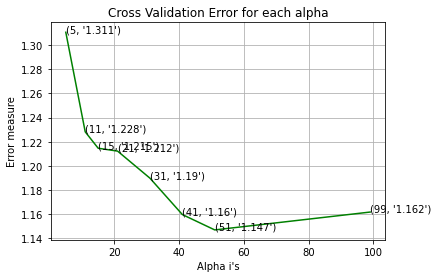

For values of best alpha =  51 The train log loss is: 0.7537491957798238
For values of best alpha =  51 The cross validation log loss is: 1.147091088973794
For values of best alpha =  51 The test log loss is: 1.215633479409617


In [141]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing the model with best hyper parameters

Log loss : 1.147091088973794
Number of mis-classified points : 0.3890977443609023
-------------------- Confusion matrix --------------------


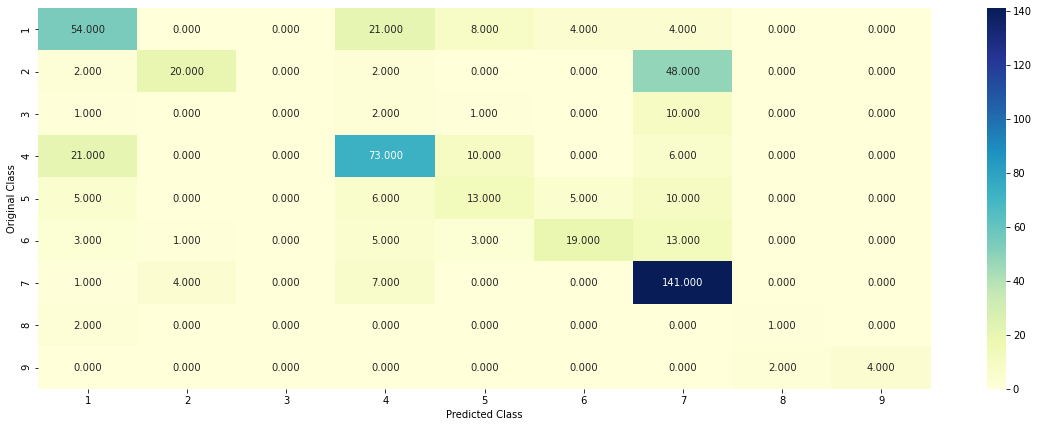

-------------------- Precision matrix (Column Sum=1) --------------------


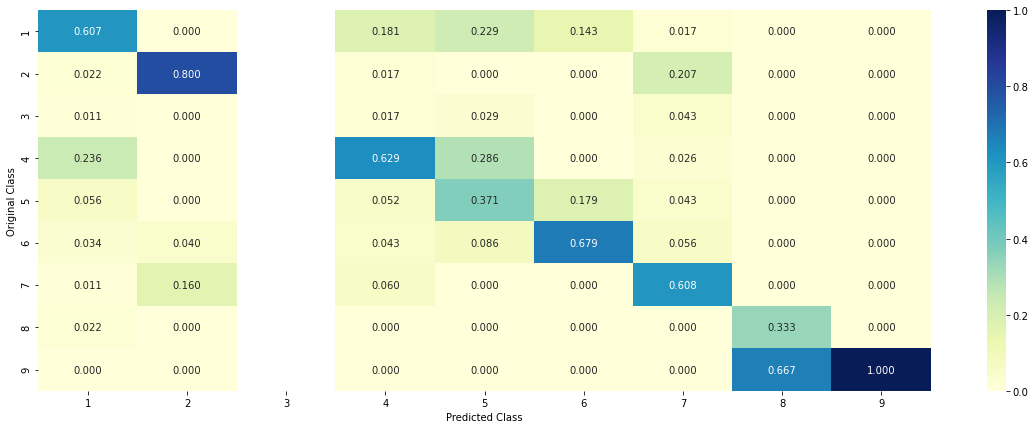

-------------------- Recall matrix (Row sum=1) --------------------


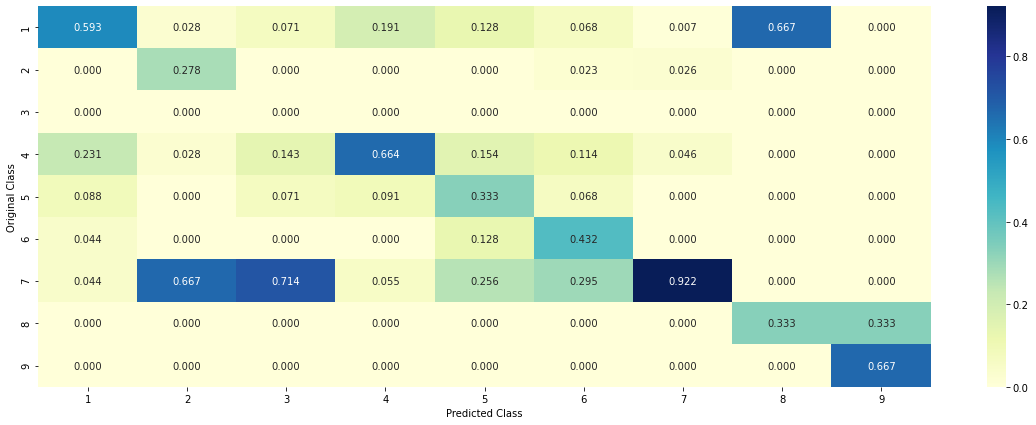

In [142]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### Sample Query Point-1

In [143]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 7
The  51  nearest neighbours of the test points belongs to classes [2 2 6 2 6 7 5 7 7 7 7 7 1 7 7 7 1 7 1 5 7 7 5 7 5 7 7 7 7 1 1 7 7 7 7 7 7
 7 2 7 7 7 7 2 8 7 7 5 7 7 5]
Fequency of nearest points : Counter({7: 32, 5: 6, 2: 5, 1: 5, 6: 2, 8: 1})


### Sample Query Point -2

In [144]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 51 and the nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 4 2 6 2 6 4 2 8 7 1 7 7]
Fequency of nearest points : Counter({7: 40, 2: 4, 1: 2, 4: 2, 6: 2, 8: 1})


## Logistic Regression

#### Hyper Parameter tuning

for alpha = 1e-06
Log Loss : 1.278981470219334
for alpha = 1e-05
Log Loss : 1.235323439948442
for alpha = 0.0001
Log Loss : 1.0576497933253557
for alpha = 0.001
Log Loss : 1.0686303655961513
for alpha = 0.01
Log Loss : 1.1727288519904249
for alpha = 0.1
Log Loss : 1.4371343099122846
for alpha = 1
Log Loss : 1.677674376897497
for alpha = 10
Log Loss : 1.7130167241213532
for alpha = 100
Log Loss : 1.7167956094862098


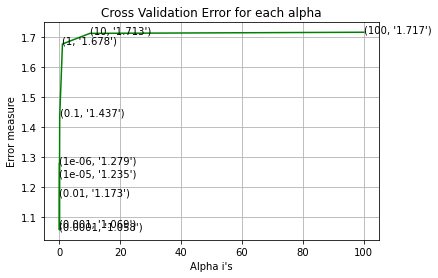

For values of best alpha =  0.0001 The train log loss is: 0.45523001452087547
For values of best alpha =  0.0001 The cross validation log loss is: 1.0576497933253557
For values of best alpha =  0.0001 The test log loss is: 1.2002081180778639


In [145]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing the Model with best hyper parameters

Log loss : 1.0576497933253557
Number of mis-classified points : 0.34022556390977443
-------------------- Confusion matrix --------------------


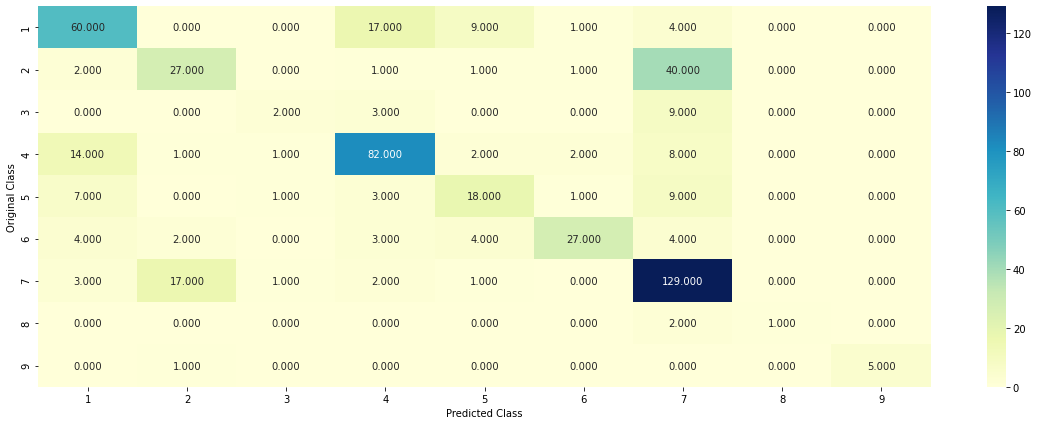

-------------------- Precision matrix (Column Sum=1) --------------------


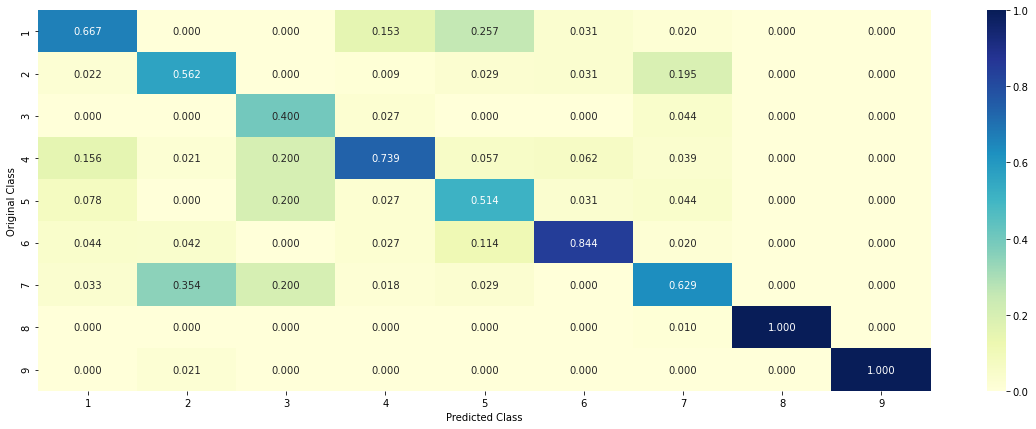

-------------------- Recall matrix (Row sum=1) --------------------


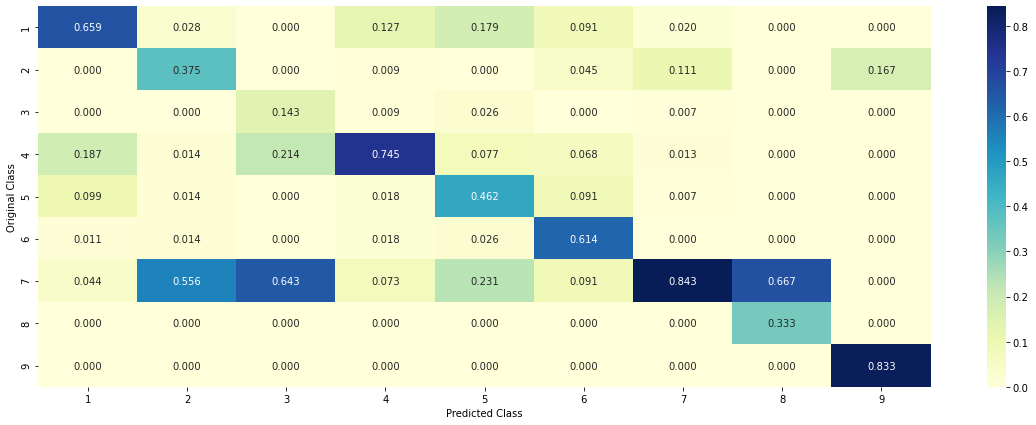

In [146]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature Importance

In [147]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

### Correctly Classified Point

In [148]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0077 0.2987 0.0007 0.0041 0.0055 0.0031 0.6669 0.0089 0.0045]]
Actual Class : 7
--------------------------------------------------
364 Text feature [constitutive] present in test data point [True]
424 Text feature [661] present in test data point [True]
Out of the top  500  features  2 are present in query point


### Incorrectly Classified point

In [85]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1033 0.1278 0.0139 0.1649 0.0731 0.0613 0.4404 0.007  0.0082]]
Actual Class : 7
--------------------------------------------------
381 Text feature [exemplified] present in test data point [True]
Out of the top  500  features  1 are present in query point


## Without class balancing

#### Hyper Parameter tuning

for alpha = 1e-06
Log Loss : 1.2568382608528796
for alpha = 1e-05
Log Loss : 1.2207691719164688
for alpha = 0.0001
Log Loss : 1.0640501606220782
for alpha = 0.001
Log Loss : 1.0653001867183305
for alpha = 0.01
Log Loss : 1.1971365350064733
for alpha = 0.1
Log Loss : 1.4022579113647697
for alpha = 1
Log Loss : 1.6377830390006551


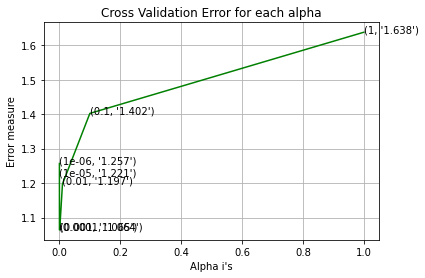

For values of best alpha =  0.0001 The train log loss is: 0.46376502349410276
For values of best alpha =  0.0001 The cross validation log loss is: 1.0640501606220782
For values of best alpha =  0.0001 The test log loss is: 1.2040314739686966


In [149]:

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing model with best hyper parameters

Log loss : 1.0640501606220782
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


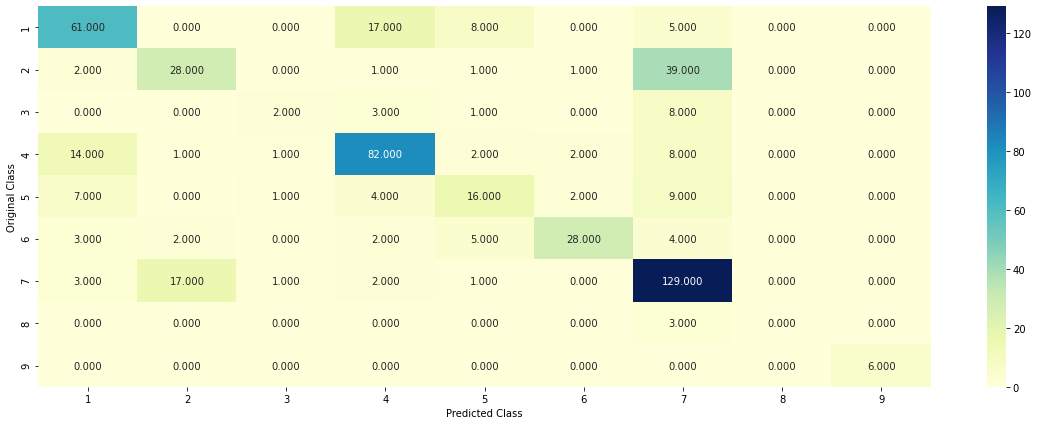

-------------------- Precision matrix (Column Sum=1) --------------------


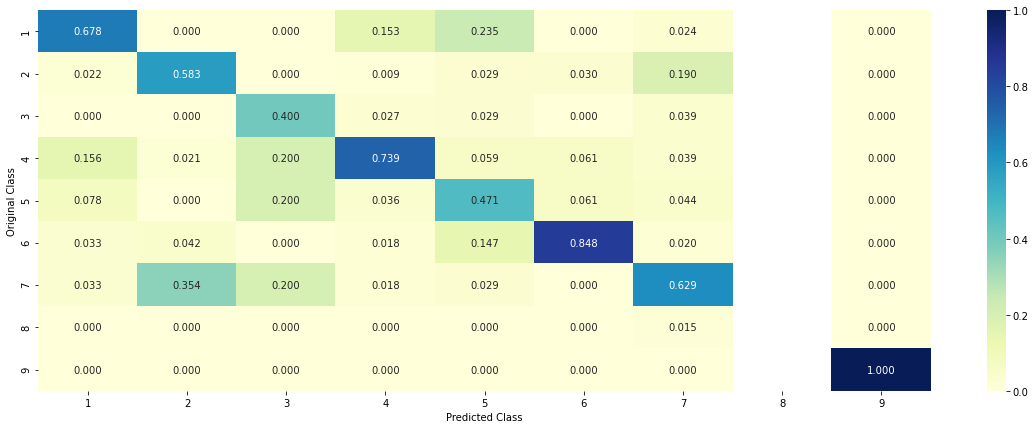

-------------------- Recall matrix (Row sum=1) --------------------


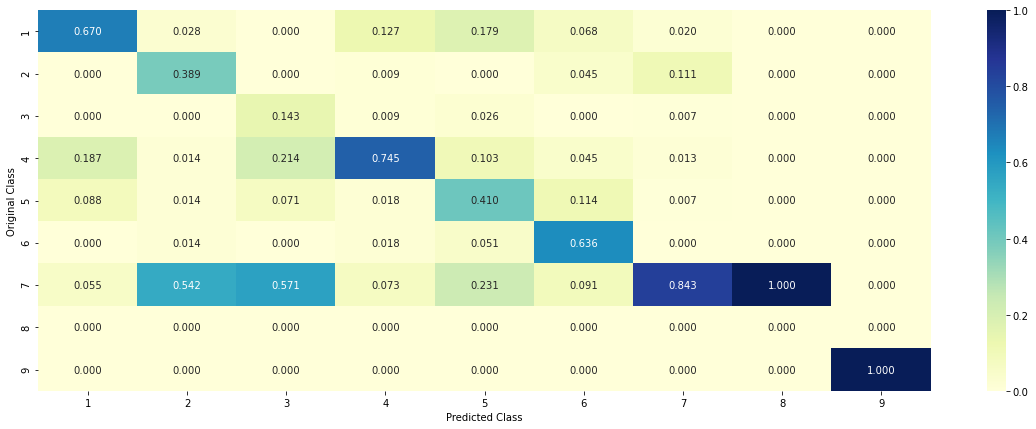

In [150]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature Importance,Correctly Classified point

In [151]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[4.100e-03 2.606e-01 7.000e-04 7.400e-03 4.800e-03 3.400e-03 7.070e-01
  6.900e-03 5.100e-03]]
Actual Class : 7
--------------------------------------------------
375 Text feature [constitutive] present in test data point [True]
404 Text feature [661] present in test data point [True]
486 Text feature [ran] present in test data point [True]
Out of the top  500  features  3 are present in query point


### Feature importance,Incorrectly Classified Point

In [89]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0959 0.1115 0.0206 0.1724 0.0622 0.0545 0.471  0.0054 0.0064]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


## Linear Support Vector Machines

#### Hyper Parameter tuning

for C = 1e-05
Log Loss : 1.2300144802166177
for C = 0.0001
Log Loss : 1.1553508448419911
for C = 0.001
Log Loss : 1.0664242668359405
for C = 0.01
Log Loss : 1.0900129687797682
for C = 0.1
Log Loss : 1.3636396851705763
for C = 1
Log Loss : 1.6939809613653454
for C = 10
Log Loss : 1.7174300880830304
for C = 100
Log Loss : 1.7174301002184604


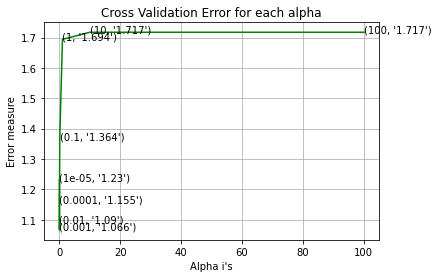

For values of best alpha =  0.001 The train log loss is: 0.4978420480415286
For values of best alpha =  0.001 The cross validation log loss is: 1.0664242668359405
For values of best alpha =  0.001 The test log loss is: 1.2154320634020697


In [152]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing model with best hyper parameters

Log loss : 1.0664242668359405
Number of mis-classified points : 0.34022556390977443
-------------------- Confusion matrix --------------------


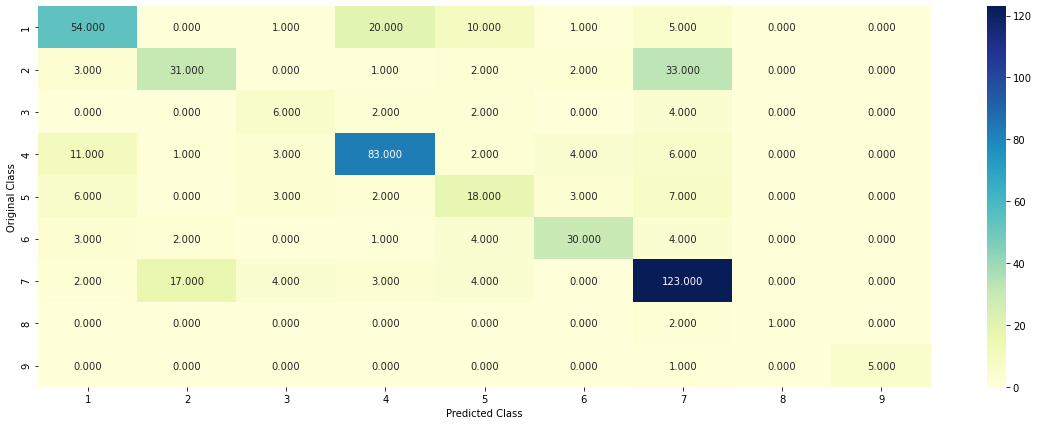

-------------------- Precision matrix (Column Sum=1) --------------------


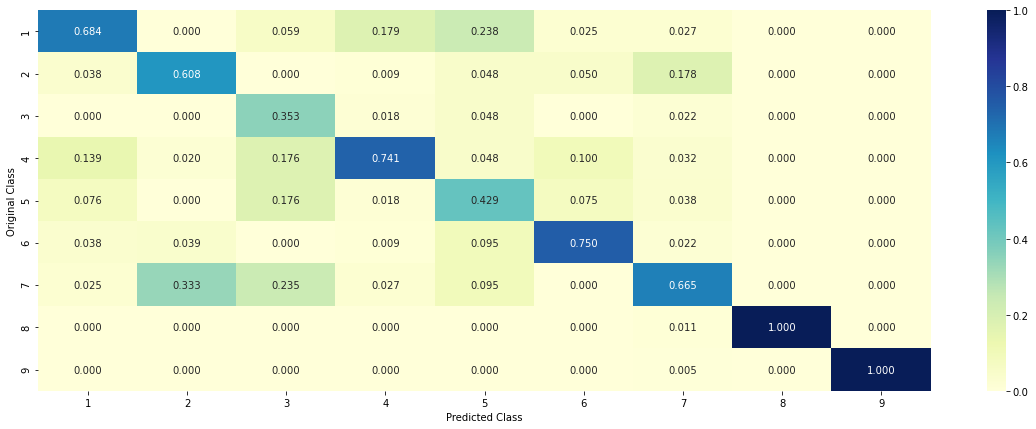

-------------------- Recall matrix (Row sum=1) --------------------


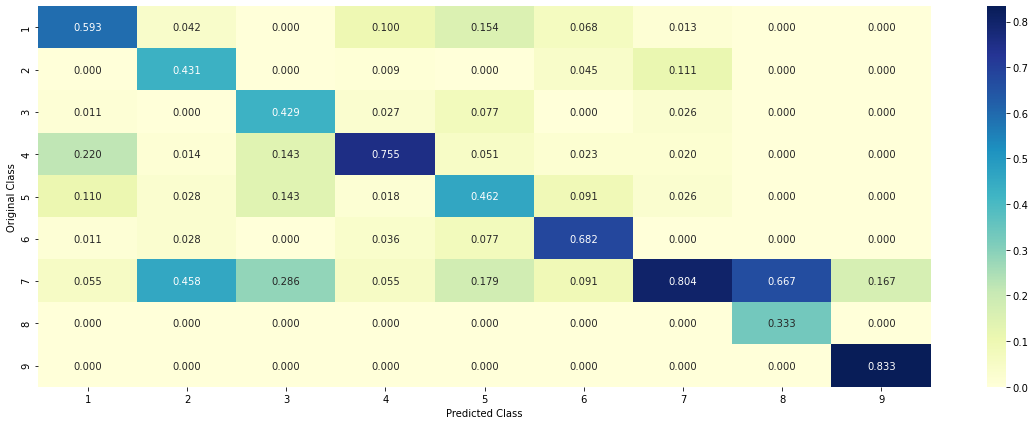

In [153]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Feature Importance

#### For Correctly Classified point

In [154]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0604 0.1954 0.0056 0.0278 0.0133 0.0193 0.6646 0.0076 0.0061]]
Actual Class : 7
--------------------------------------------------
197 Text feature [661] present in test data point [True]
Out of the top  500  features  1 are present in query point


### For Incorrectly Classified Point

In [93]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0922 0.1196 0.0117 0.1621 0.0643 0.0511 0.4856 0.006  0.0073]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


## Random Forest Classifier

#### Hyper Parameter tuning(With one hot Encoding)

In [155]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2380438581893507
for n_estimators = 100 and max depth =  10
Log Loss : 1.1575118354941913
for n_estimators = 200 and max depth =  5
Log Loss : 1.226674635031786
for n_estimators = 200 and max depth =  10
Log Loss : 1.151395268696383
for n_estimators = 500 and max depth =  5
Log Loss : 1.2099376419523946
for n_estimators = 500 and max depth =  10
Log Loss : 1.1373595589075733
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2095833059550782
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1350396084570291
for n_estimators = 2000 and max depth =  5
Log Loss : 1.20805833444123
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1326831302861837
For values of best estimator =  2000 The train log loss is: 0.646361218946726
For values of best estimator =  2000 The cross validation log loss is: 1.1326831302861837
For values of best estimator =  2000 The test log loss is: 1.1601850090284862


### Testing model with best Hyper Parameters (One Hot Coding)

Log loss : 1.1326831302861837
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


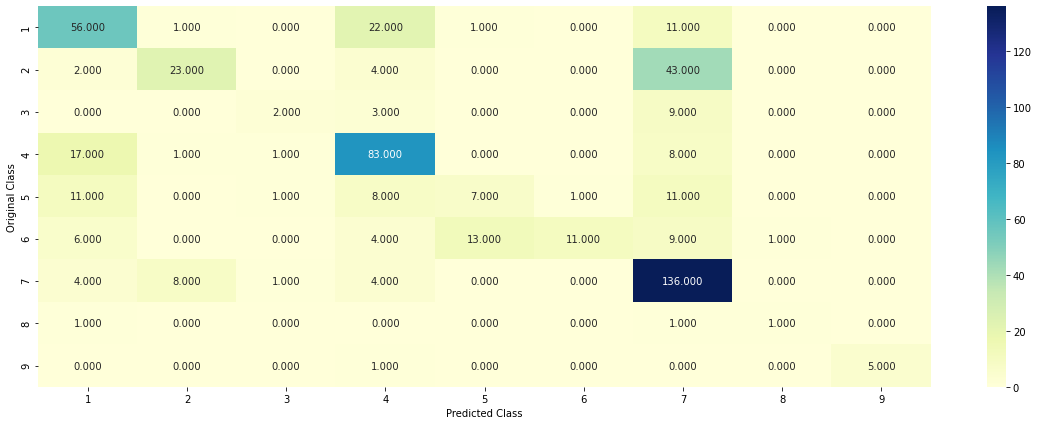

-------------------- Precision matrix (Column Sum=1) --------------------


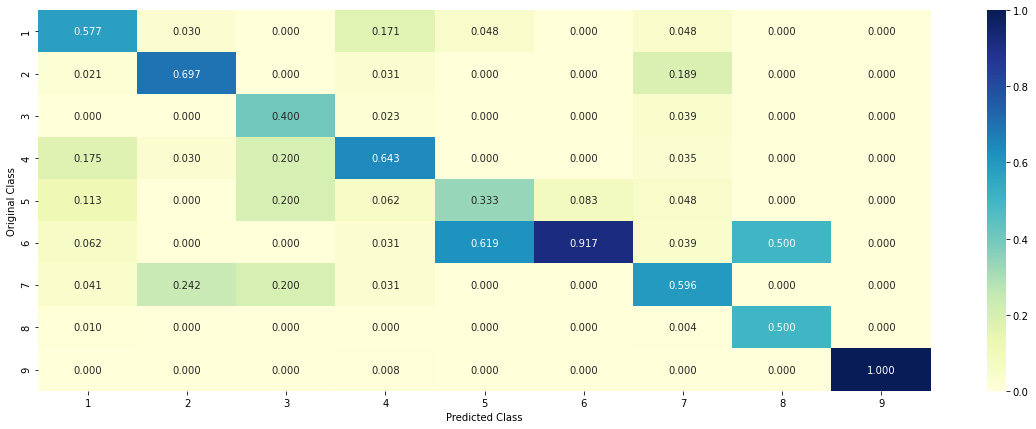

-------------------- Recall matrix (Row sum=1) --------------------


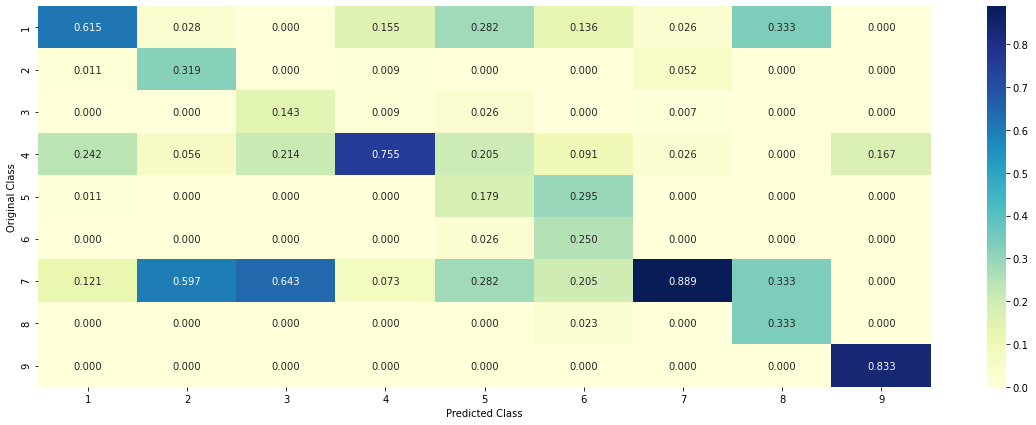

In [156]:

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Feature Importance

### Correctly Classified Point

In [157]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0348 0.1651 0.012  0.029  0.0361 0.0319 0.681  0.0058 0.0043]]
Actual Class : 7
--------------------------------------------------
0 Text feature [activating] present in test data point [True]
1 Text feature [kinase] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
7 Text feature [constitutive] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
13 Text feature [growth] present in test data point [True]
14 Text feature [signaling] present in test data point [True]
19 Text feature [treatment] present in test data point [True]
21 Text feature [loss] present in test data point [True]
22 Text feature 

### Incorrectly Classified Point

In [97]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0333 0.193  0.0201 0.0375 0.043  0.0362 0.6239 0.0094 0.0036]]
Actuall Class : 7
--------------------------------------------------
0 Text feature [activating] present in test data point [True]
1 Text feature [constitutive] present in test data point [True]
2 Text feature [kinase] present in test data point [True]
3 Text feature [growth] present in test data point [True]
4 Text feature [trials] present in test data point [True]
13 Text feature [tyrosine] present in test data point [True]
15 Text feature [drugs] present in test data point [True]
16 Text feature [receptor] present in test data point [True]
17 Text feature [proteins] present in test data point [True]
18 Text feature [oncogenic] present in test data point [True]
21 Text feature [inhibitors] present in test data point [True]
22 Text feature [activated] present in test data point [True]
25 Text feature [proliferation] present in test data point [True]
27 Text feature [fa

### Hyper Parameter tuning (with response coding)

In [158]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.8783611939126998
for n_estimators = 10 and max depth =  3
Log Loss : 1.734941633584346
for n_estimators = 10 and max depth =  5
Log Loss : 1.6745461697235071
for n_estimators = 10 and max depth =  10
Log Loss : 1.8335093893232017
for n_estimators = 50 and max depth =  2
Log Loss : 1.5513333593768137
for n_estimators = 50 and max depth =  3
Log Loss : 1.4701163251334202
for n_estimators = 50 and max depth =  5
Log Loss : 1.4106890193897974
for n_estimators = 50 and max depth =  10
Log Loss : 1.7460351776523657
for n_estimators = 100 and max depth =  2
Log Loss : 1.473164660162445
for n_estimators = 100 and max depth =  3
Log Loss : 1.4463365770185268
for n_estimators = 100 and max depth =  5
Log Loss : 1.3858884959071718
for n_estimators = 100 and max depth =  10
Log Loss : 1.7460371705565363
for n_estimators = 200 and max depth =  2
Log Loss : 1.5012687524144697
for n_estimators = 200 and max depth =  3
Log Loss : 1.4459442559641498

### Testing model with best hyper parameters ( Response Coding)

Log loss : 1.3549948421446603
Number of mis-classified points : 0.5075187969924813
-------------------- Confusion matrix --------------------


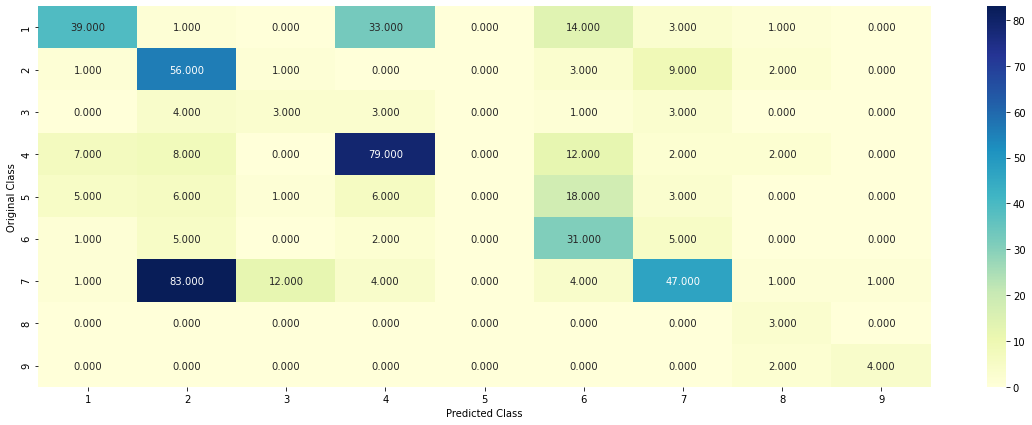

-------------------- Precision matrix (Column Sum=1) --------------------


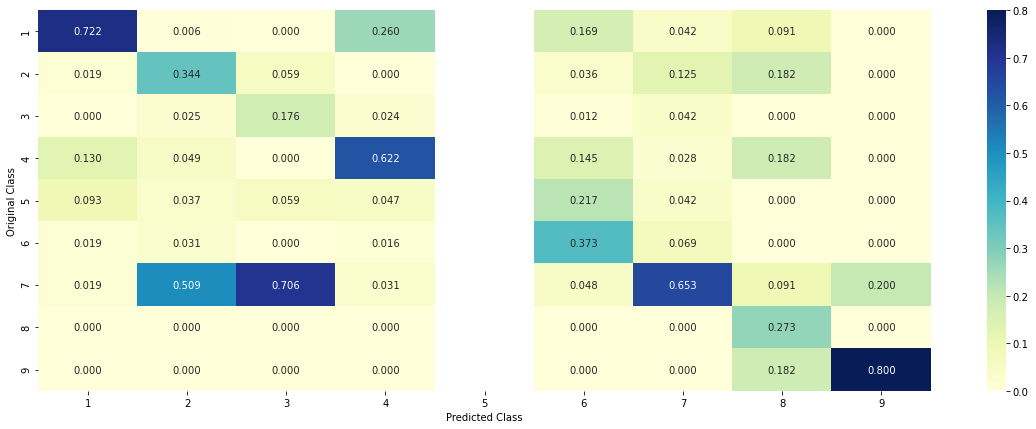

-------------------- Recall matrix (Row sum=1) --------------------


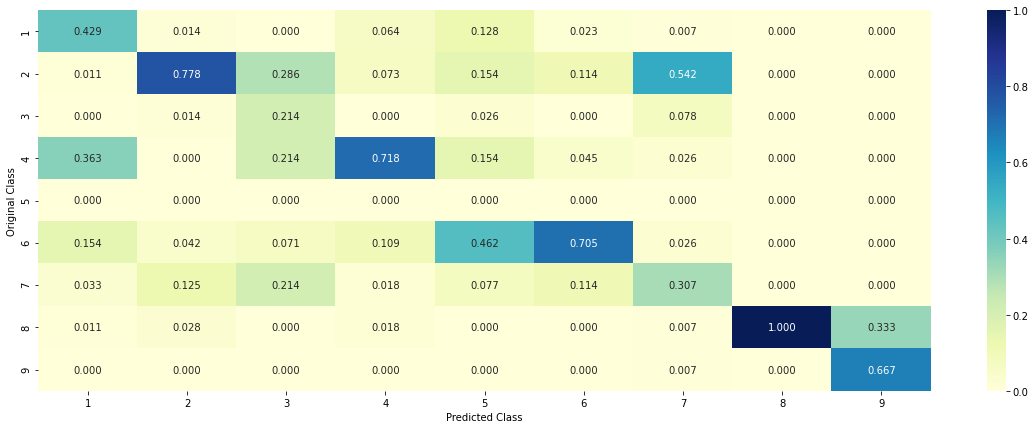

In [159]:

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

## Feature Importance

#### Correctly Classified point

In [160]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0915 0.116  0.0839 0.0577 0.137  0.1221 0.2715 0.0815 0.0388]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature


#### Incorrectly Classified Point

In [101]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.1204 0.0215 0.0287 0.0236 0.1643 0.0968 0.3165 0.0804 0.1478]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature


### Testing with hyper parameter tuning

In [161]:


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.07
Support vector machines : Log Loss: 1.69
Naive Bayes : Log Loss: 1.18
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.718
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.304
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.117
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.368
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.644


### Testing the model with the best Hyper Parameters

Log loss (train) on the stacking classifier : 0.4793372501962449
Log loss (CV) on the stacking classifier : 1.1172678333107768
Log loss (test) on the stacking classifier : 1.2349462623575926
Number of missclassified point : 0.37894736842105264
-------------------- Confusion matrix --------------------


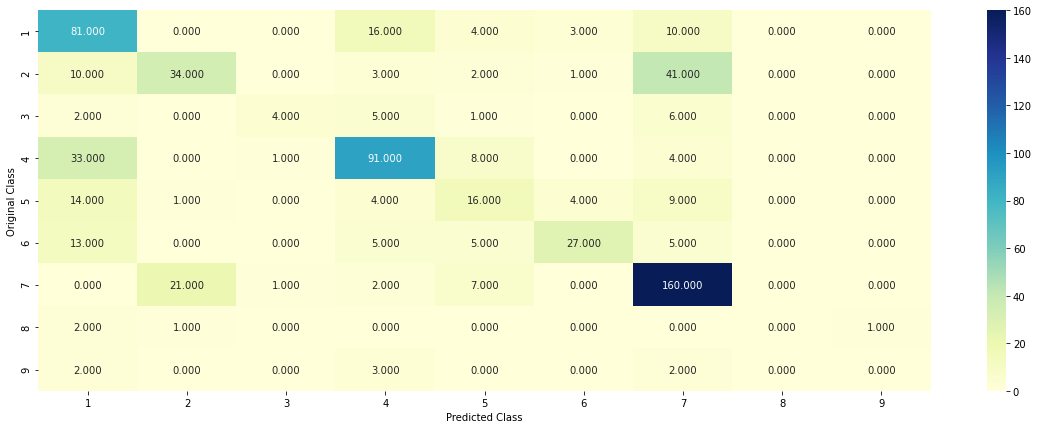

-------------------- Precision matrix (Column Sum=1) --------------------


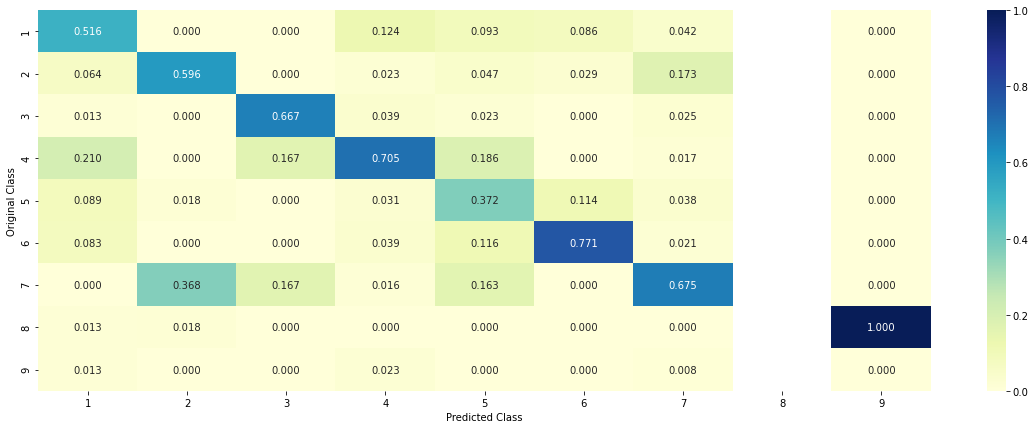

-------------------- Recall matrix (Row sum=1) --------------------


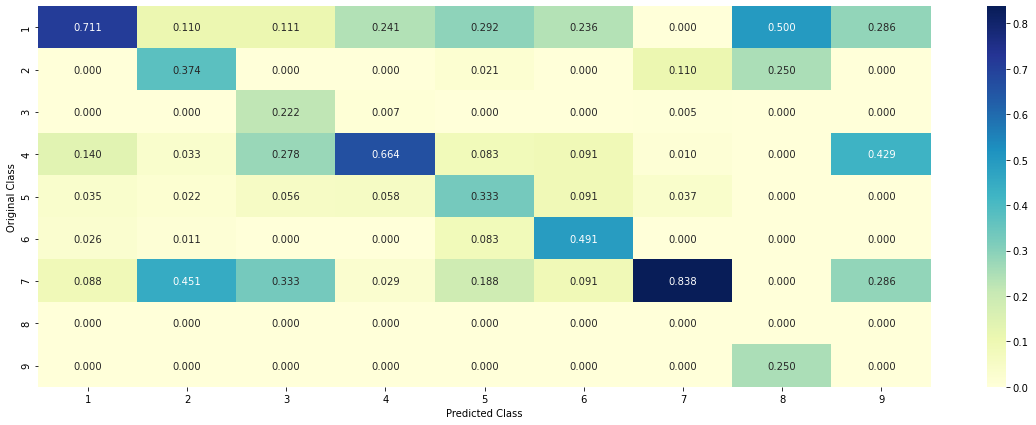

In [162]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8510878767116534
Log loss (CV) on the VotingClassifier : 1.1330340537755015
Log loss (test) on the VotingClassifier : 1.254297535139052
Number of missclassified point : 0.3744360902255639
-------------------- Confusion matrix --------------------


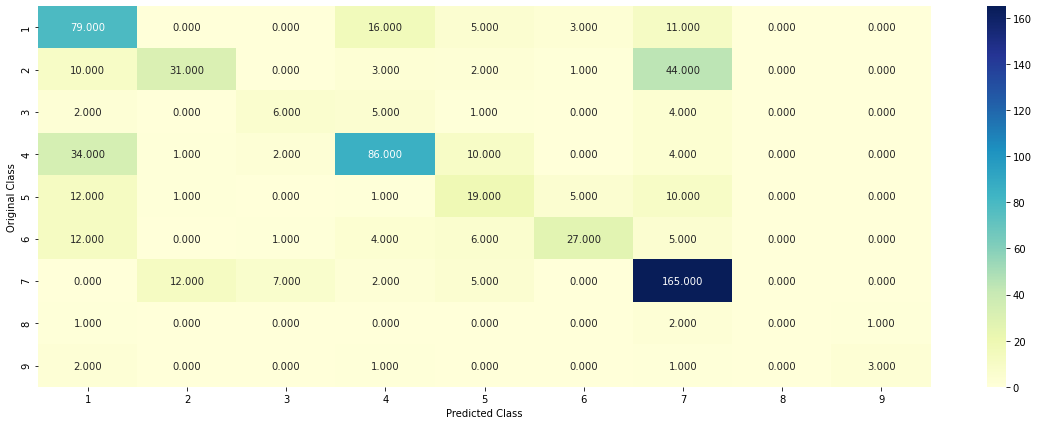

-------------------- Precision matrix (Column Sum=1) --------------------


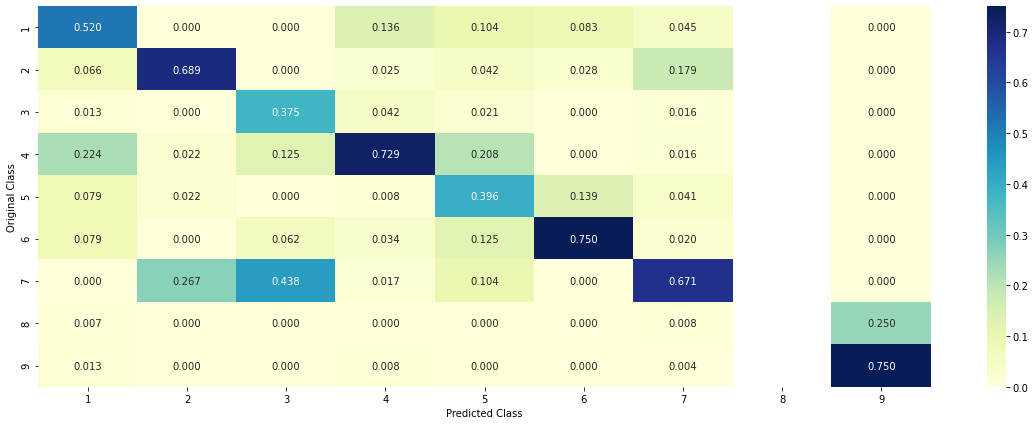

-------------------- Recall matrix (Row sum=1) --------------------


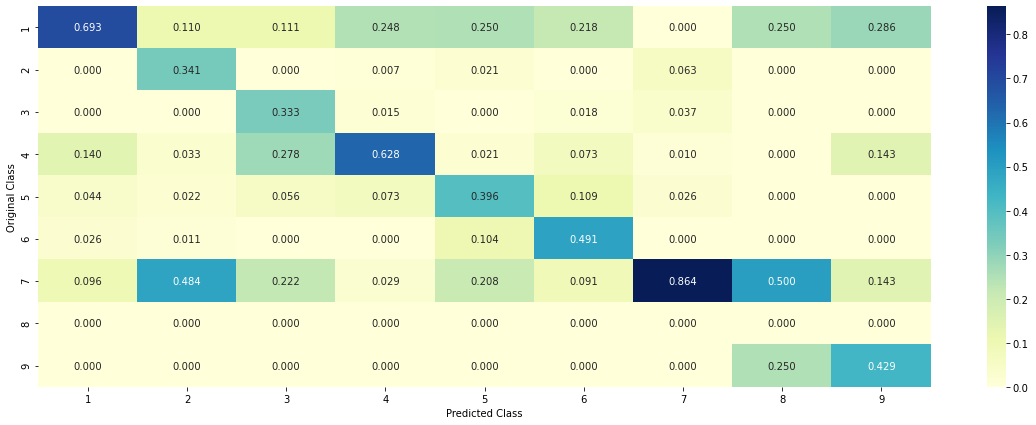

In [163]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))